### Зависимости

In [2]:
%pip install dotenv
%pip install boto3

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 2.1 MB/s eta 0:00:00
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of te

### Библиотеки

In [4]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller

import boto3
from dotenv import dotenv_values, find_dotenv

from io import StringIO
from tqdm import tqdm
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

### Данные

In [5]:
# подкобчение
config = dotenv_values(find_dotenv("env.txt"))
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = config['AWS_SECRET_ACCESS_KEY']
)

In [6]:
bytes_data = s3.get_object(Bucket='finrisk-lake', Key="/base_active/combain_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8'))

data = pd.read_csv(csv_data).bfill()
data['begin'] = pd.to_datetime(data['begin'])
data

,begin,SU26207RMFS9,SU26225RMFS1,SU26229RMFS3,SU26233RMFS5,SU26235RMFS0,period_0.25,period_0.5,period_0.75,period_1.0,...,LKOH,AFLT,GMKN,NVTK,SBER,AFKS,CHMF,ROSN,VTBR,RASP
0,2021-01-04,113.929,109.001,108.041,98.250,100.449,4.03,4.09,4.14,4.20,...,5213.0,72.06,243.1,1250.4,272.00,29.03,1343.2,436.00,189.63,157.30
1,2021-01-05,113.952,109.237,108.147,98.640,100.478,3.98,4.04,4.11,4.18,...,5359.0,72.74,246.8,1287.4,275.20,29.60,1334.2,449.35,192.22,156.50
2,2021-01-06,113.700,109.300,108.180,98.623,101.000,3.85,3.95,4.04,4.11,...,5377.0,72.96,250.2,1301.2,272.93,29.28,1326.4,453.70,191.18,157.36
3,2021-01-08,113.702,109.290,108.197,98.341,100.750,3.78,3.88,3.99,4.08,...,5557.0,73.58,265.4,1379.2,283.64,29.44,1369.2,478.20,194.70,158.56
4,2021-01-11,113.368,108.299,107.748,97.390,99.800,4.17,4.19,4.22,4.26,...,5599.0,74.08,262.9,1405.4,289.49,30.24,1351.2,473.25,199.45,158.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,2024-12-25,84.881,60.205,92.087,56.438,61.890,18.33,18.33,18.30,18.24,...,6988.0,54.86,108.0,929.4,271.69,14.15,1161.8,581.95,76.53,250.25
998,2024-12-26,85.380,60.396,92.153,56.741,62.480,17.97,17.99,17.98,17.96,...,7003.0,55.04,109.7,949.8,269.56,14.09,1174.4,579.10,75.74,248.05
999,2024-12-27,85.404,60.348,92.348,56.731,62.440,17.49,17.59,17.64,17.67,...,6991.0,55.65,111.0,949.2,271.20,14.28,1186.2,591.00,76.49,251.20
1000,2024-12-28,84.927,60.318,92.084,57.136,63.059,18.55,18.58,18.57,18.53,...,6998.0,58.38,113.8,951.8,272.83,14.74,1232.2,596.00,78.09,252.05


In [7]:
# сплит данных по дате отсечения
test_date = '2024-12-01'
train_data = data[data['begin'] <= test_date]
test_data = data[data['begin'] > test_date]

In [8]:
data.columns

Index(['begin', 'SU26207RMFS9', 'SU26225RMFS1', 'SU26229RMFS3', 'SU26233RMFS5',
       'SU26235RMFS0', 'period_0.25', 'period_0.5', 'period_0.75',
       'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0',
       'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0', 'IMOEX',
       'RTSI', 'euro_cb', 'oil_price', 'usd_cb', 'ruonia', 'LKOH', 'AFLT',
       'GMKN', 'NVTK', 'SBER', 'AFKS', 'CHMF', 'ROSN', 'VTBR', 'RASP'],
      dtype='object')

### Понижение размерности факторов

In [9]:
debt_set = ['SU26207RMFS9', 'SU26225RMFS1', 'SU26229RMFS3', 'SU26233RMFS5', 'SU26235RMFS0']
market_set = ['LKOH', 'AFLT', 'GMKN', 'NVTK', 'SBER', 'AFKS', 'CHMF', 'ROSN', 'VTBR', 'RASP']
currency_set = ['euro_cb', 'usd_cb']
active_set = ['oil_price']
index_set = ['IMOEX','RTSI']
rate_set = ['ruonia', 'period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0', 
            'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0']

In [10]:
def create_factor(factor_df:pd.DataFrame, pipe:Optional[Pipeline], n=1) -> np.array:
    """
    Понижаем размерность факторов

    Args:
      factor_df: таблица для понижения размерности
      pipe (Pipeline): если не None, то делает трансформацию без обучения
      n (int): число компонент

    Returns:
        factor (np.array): получившийся фактор
    """
    if pipe is None:
        pipe = Pipeline([
          ('scaling', StandardScaler()),
          ('pca', PCA(n_components=n))
          ])
        factor = pipe.fit_transform(factor_df)
    else:
        factor = pipe.transform(factor_df)

    factor = factor.squeeze()
    return pipe, factor

In [11]:
pipe, debt_feature_train = create_factor(train_data[debt_set], None, n=1)
_, debt_feature_test = create_factor(test_data[debt_set], pipe, n=1)

pipe, market_feature_train = create_factor(train_data[market_set], None, n=1)
_, market_feature_test = create_factor(test_data[market_set], pipe, n=1)

pipe, currency_feature_train = create_factor(train_data[currency_set], None, n=1)
_, currency_feature_test = create_factor(test_data[currency_set], pipe, n=1)

pipe, active_feature_train = create_factor(train_data[active_set], None, n=1)
_, active_feature_test = create_factor(test_data[active_set], pipe, n=1)

pipe, index_feature_train = create_factor(train_data[index_set], None, n=1)
_, index_feature_test = create_factor(test_data[index_set], pipe, n=1)

pipe, rate_feature_train = create_factor(train_data[rate_set], None, n=1)
_, rate_feature_test = create_factor(test_data[rate_set], pipe, n=1)

In [12]:
risk_factors_train = pd.DataFrame({
    "date":train_data['begin'],
    "debt":debt_feature_train,
    "market":market_feature_train,
    "currency":currency_feature_train,
    "active":active_feature_train,
    "index":index_feature_train,
    "rate":rate_feature_train
})

risk_factors_test = pd.DataFrame({
    "date":test_data['begin'],
    "debt":debt_feature_test,
    "market":market_feature_test,
    "currency":currency_feature_test,
    "active":active_feature_test,
    "index":index_feature_test,
    "rate":rate_feature_test
})

factor_cols = risk_factors_train.columns[1:]
risk_factors_train

,date,debt,market,currency,active,index,rate
0,2021-01-04,4.833340,0.986277,-0.132085,-2.566957,0.921360,-5.330986
1,2021-01-05,4.866545,1.193081,-0.132085,-2.333917,0.934759,-5.366392
2,2021-01-06,4.879170,1.213974,-0.132085,-2.287309,0.976413,-5.394457
3,2021-01-08,4.859870,1.657052,-0.132085,-2.109716,1.152208,-5.416577
4,2021-01-11,4.695394,1.746828,-0.132085,-2.169181,1.184597,-5.267520
...,...,...,...,...,...,...,...
975,2024-11-25,-4.000206,-1.729604,2.389796,-0.764511,-1.756969,8.309309
976,2024-11-26,-4.029000,-1.892247,2.534228,-0.778976,-1.910830,8.425346
977,2024-11-27,-4.050167,-1.656000,2.690943,-0.775762,-1.910628,8.565390
978,2024-11-28,-4.067969,-1.698748,2.995456,-0.758886,-1.830419,8.543066


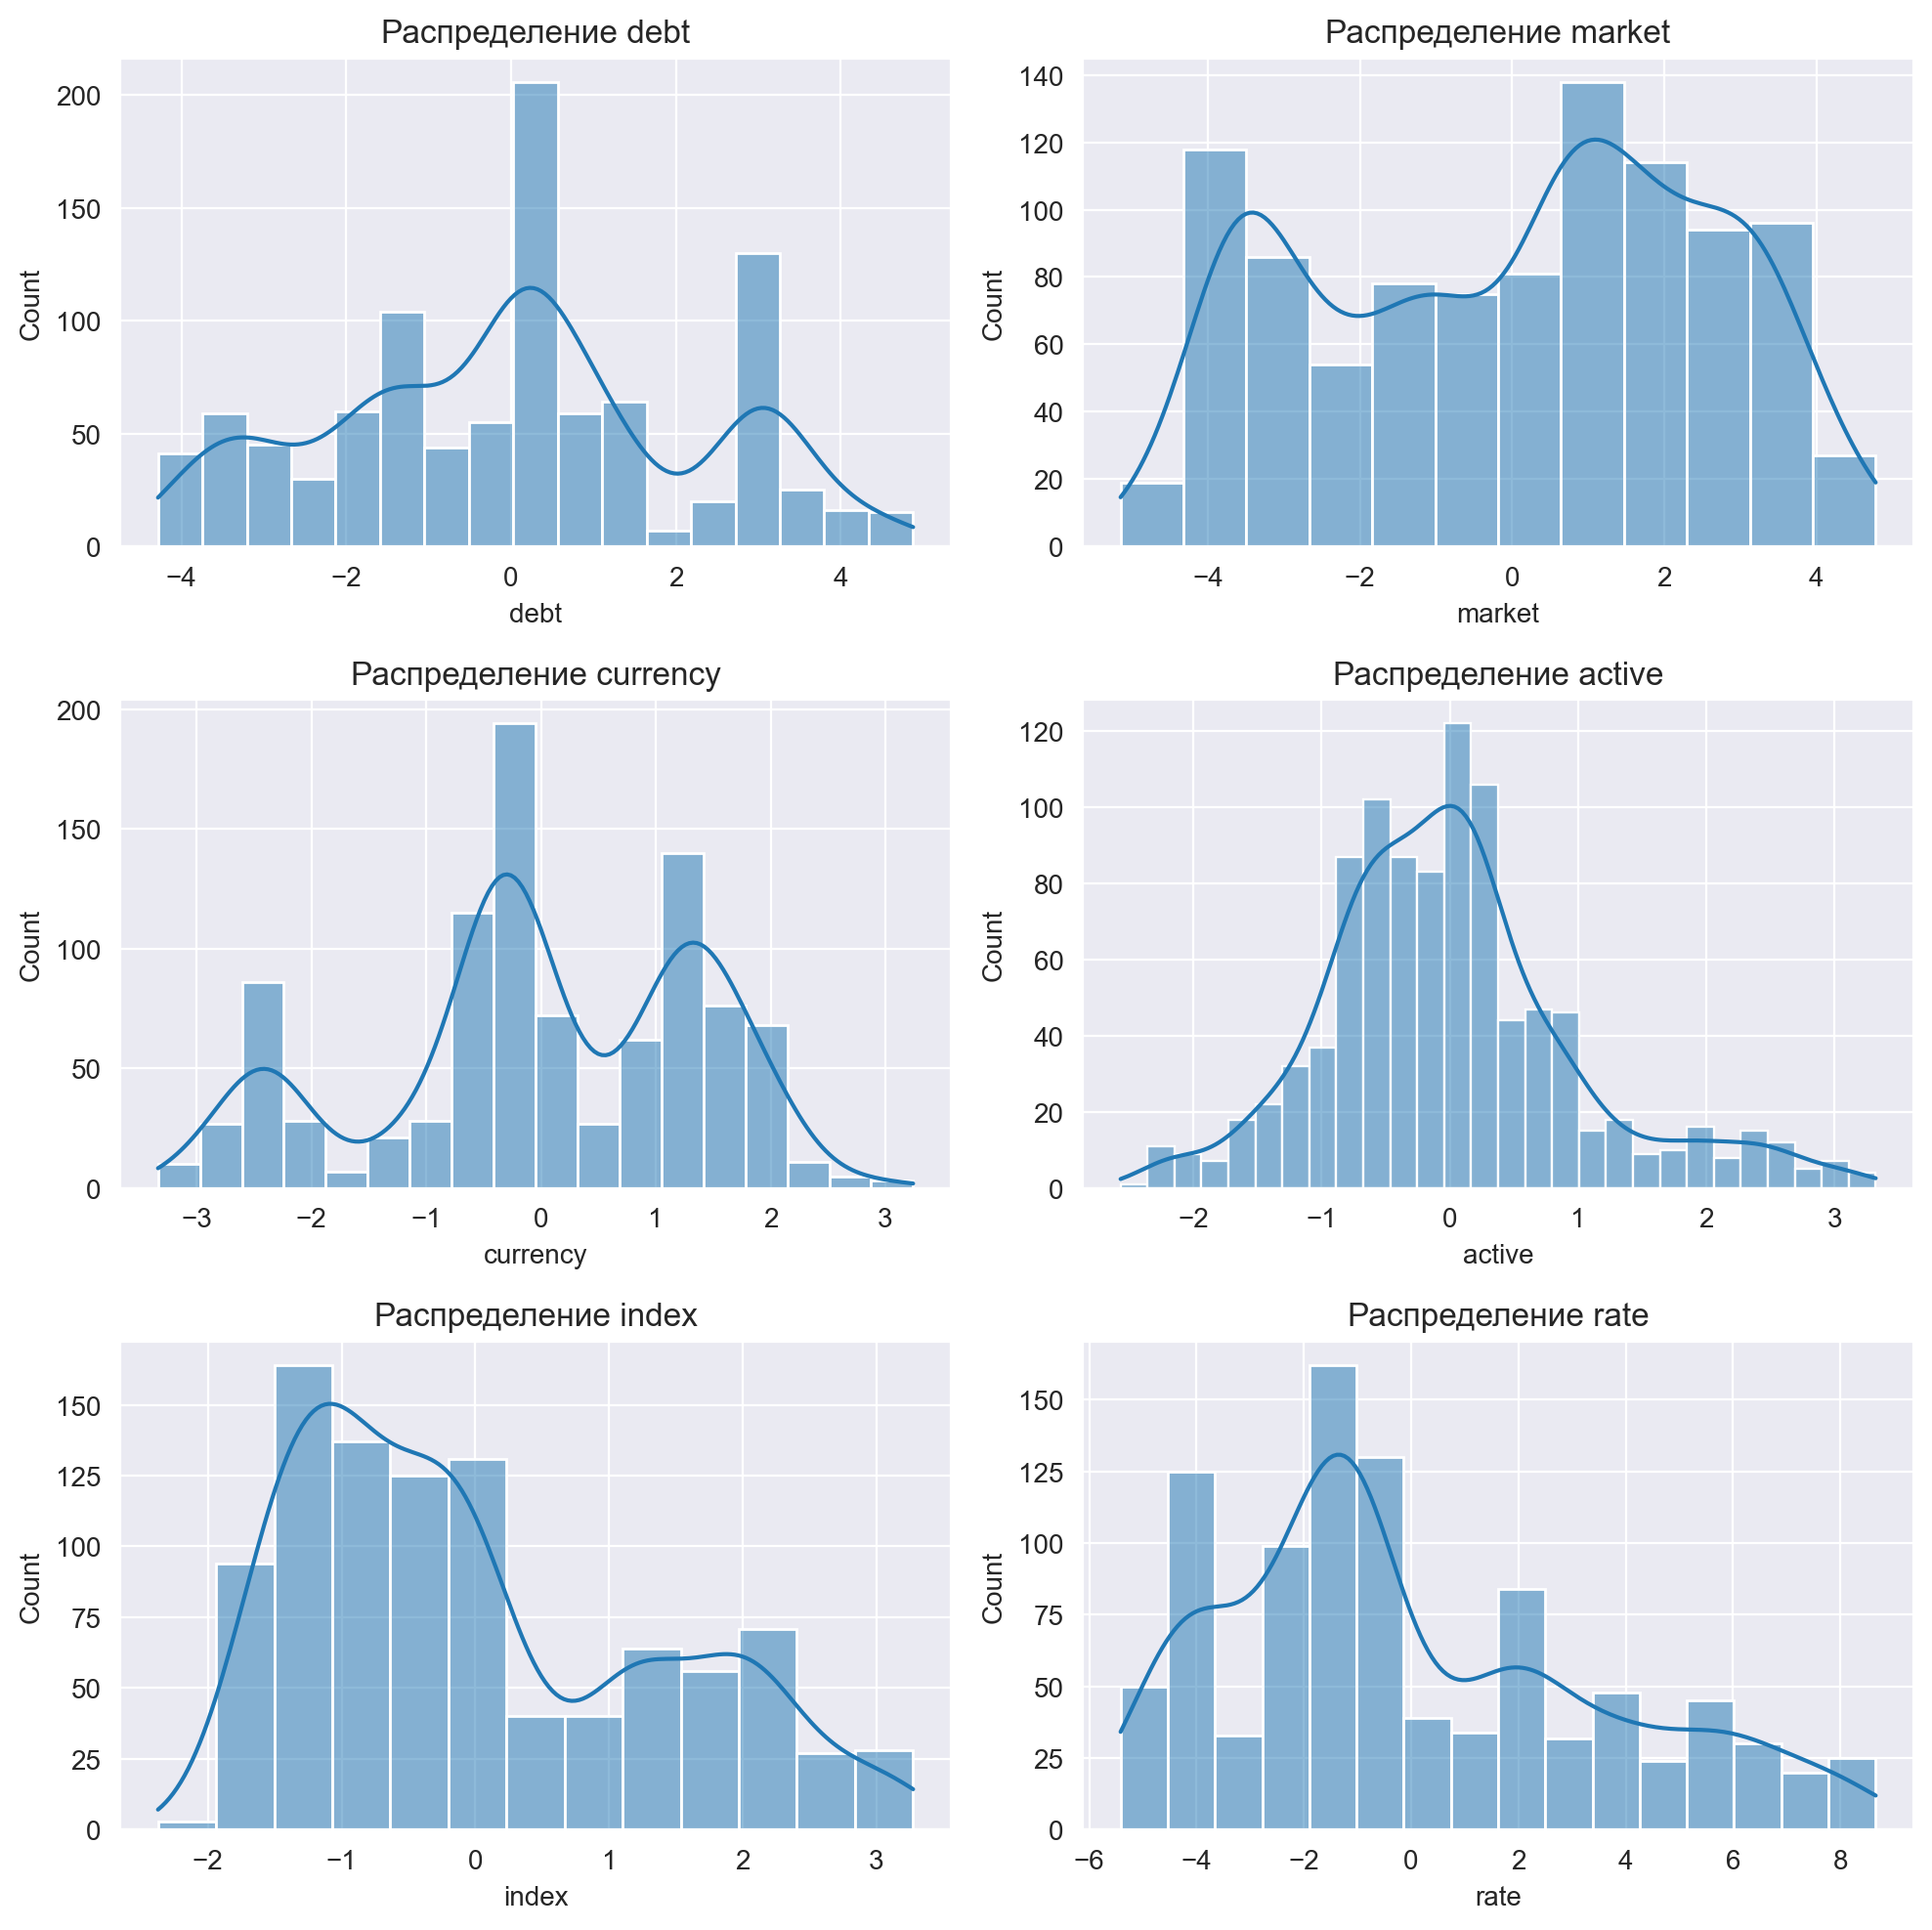

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.histplot(data=risk_factors_train, x='debt', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Распределение debt')

sns.histplot(data=risk_factors_train, x='market', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Распределение market')

sns.histplot(data=risk_factors_train, x='currency', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Распределение currency')

sns.histplot(data=risk_factors_train, x='active', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Распределение active')

sns.histplot(data=risk_factors_train, x='index', kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Распределение index')

sns.histplot(data=risk_factors_train, x='rate', kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Распределение rate')

plt.tight_layout()
plt.show()

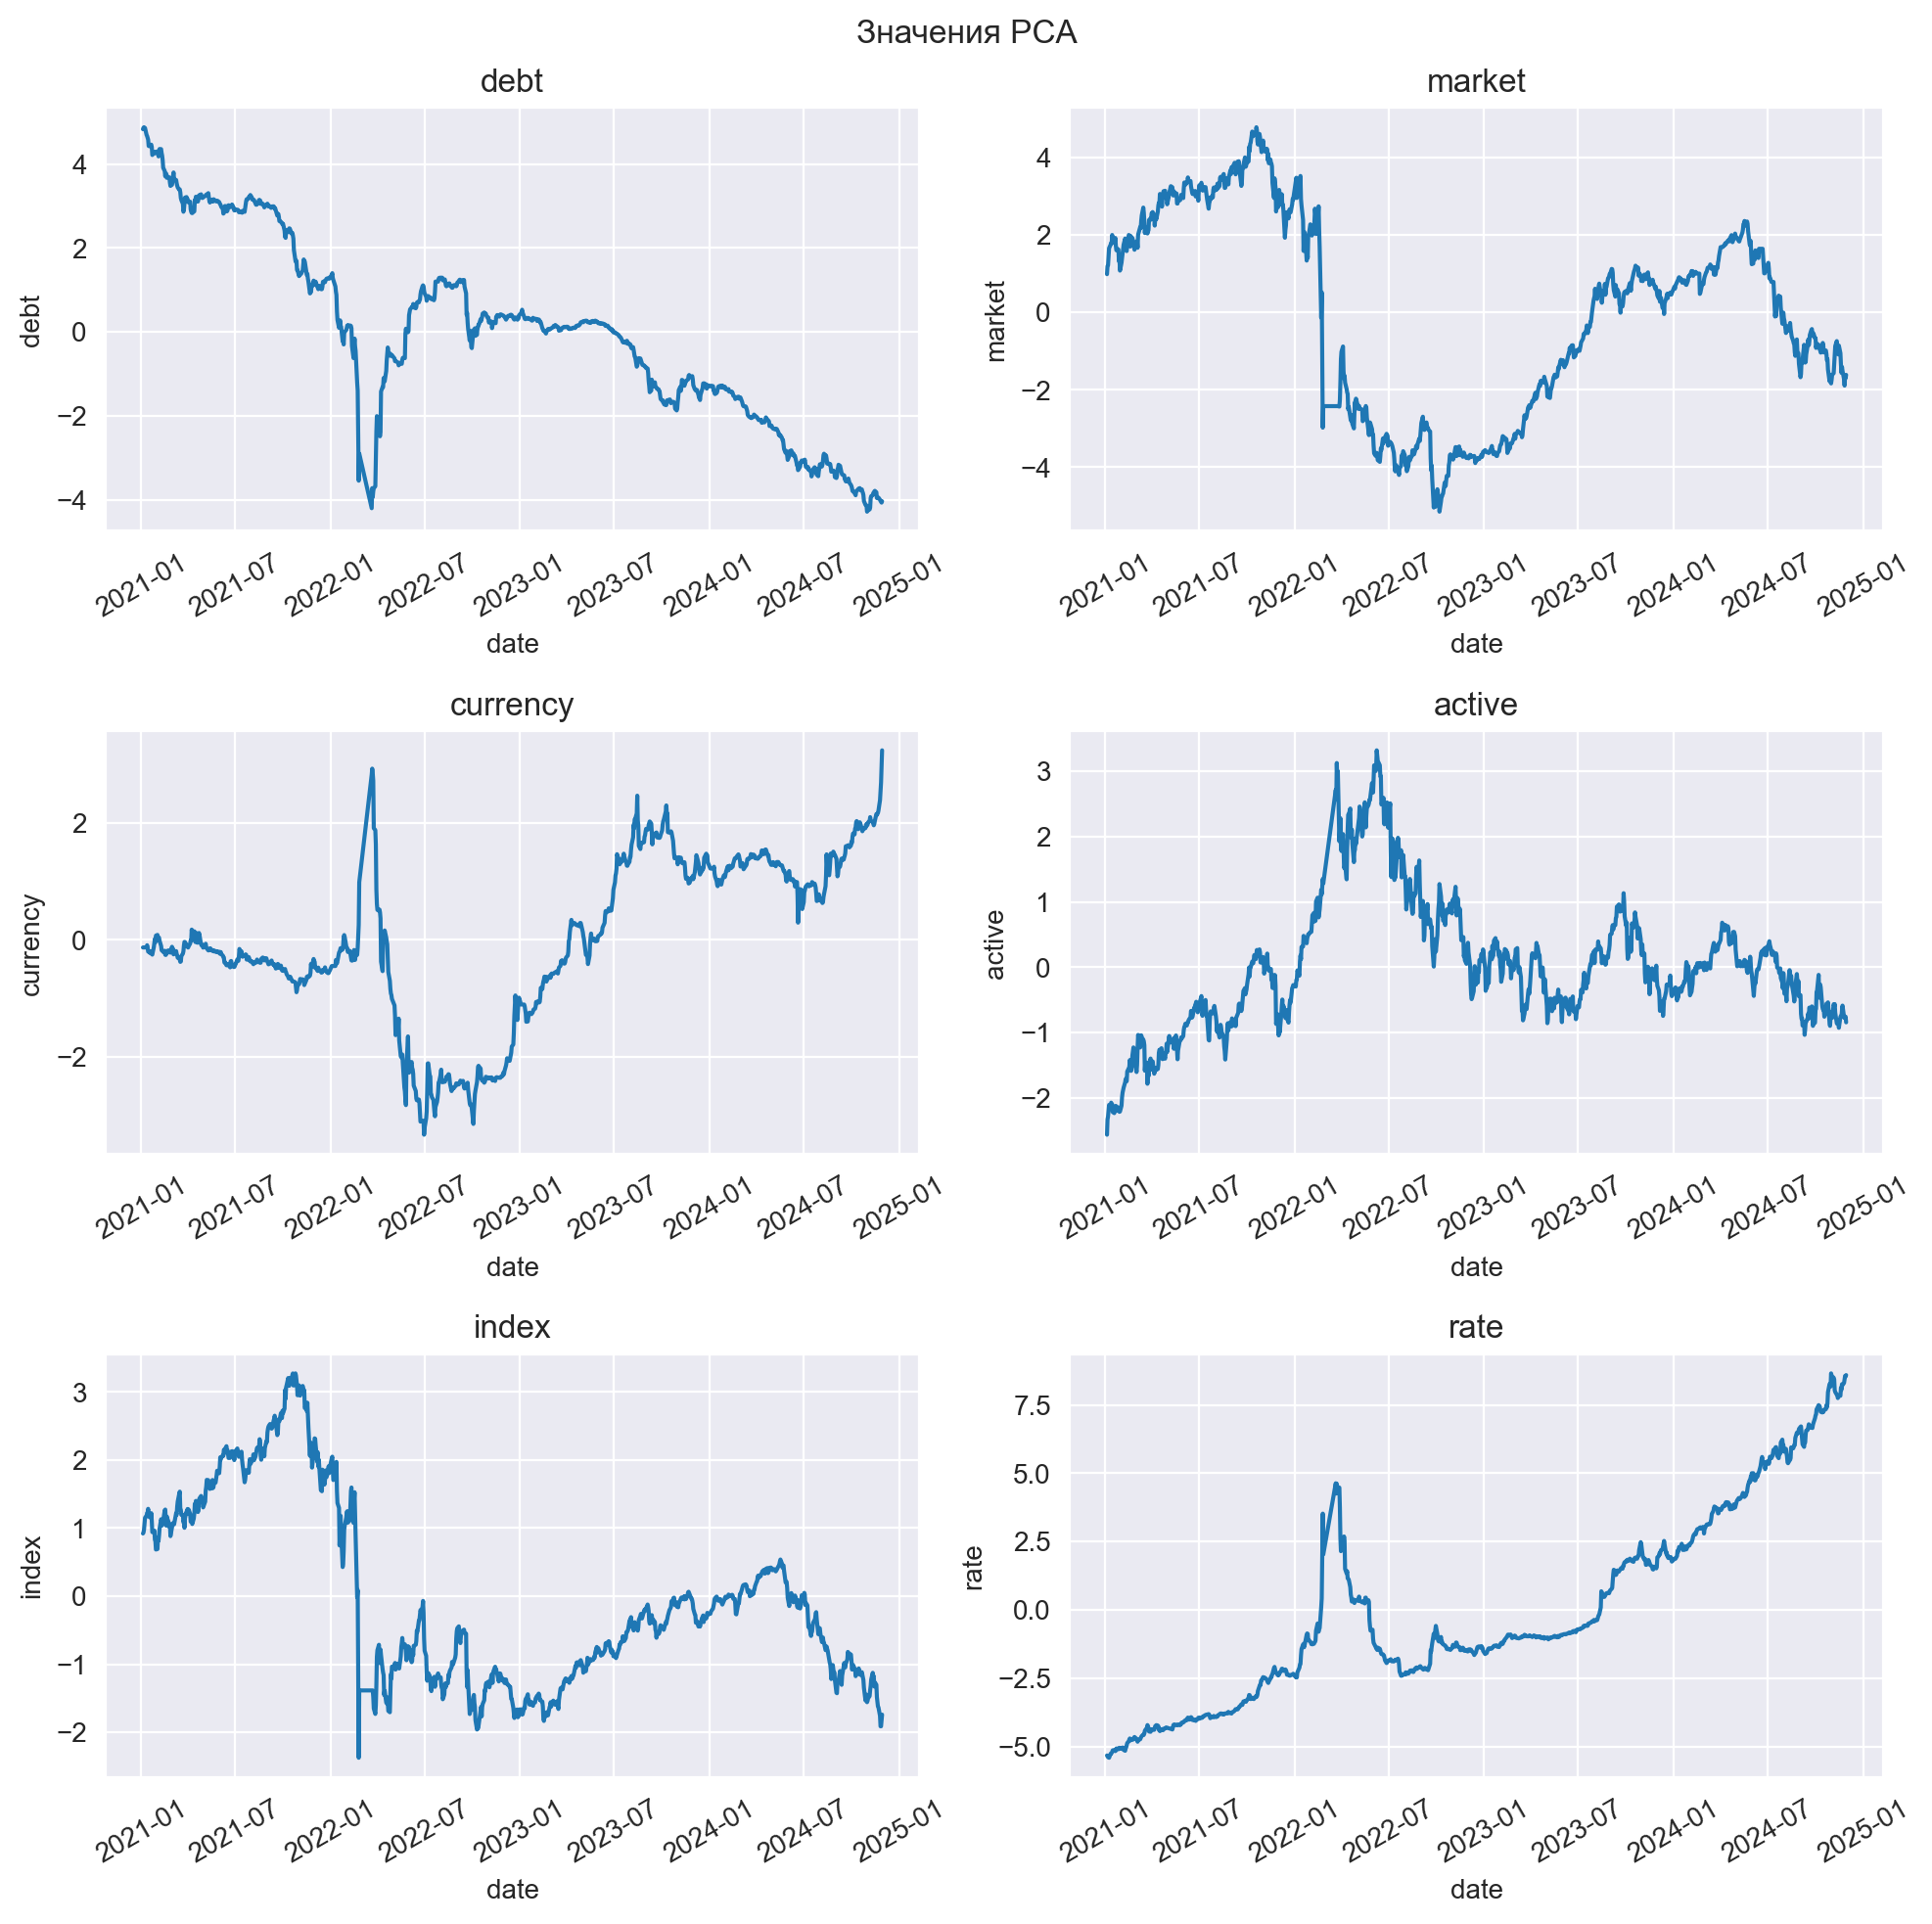

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.lineplot(data=risk_factors_train, x='date', y='debt', ax=axes[0, 0])
axes[0, 0].set_title('debt')
axes[0, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='market', ax=axes[0, 1])
axes[0, 1].set_title('market')
axes[0, 1].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='currency', ax=axes[1, 0])
axes[1, 0].set_title('currency')
axes[1, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='active', ax=axes[1, 1])
axes[1, 1].set_title('active')
axes[1, 1].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='index', ax=axes[2, 0])
axes[2, 0].set_title('index')
axes[2, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='rate', ax=axes[2, 1])
axes[2, 1].set_title('rate')
axes[2, 1].tick_params(axis='x', rotation=30)

plt.suptitle('Значения PCA')
plt.tight_layout()
plt.show()

In [15]:
# стационарность (базоый кейс)
for col in factor_cols:
    result = adfuller(risk_factors_train[col])
    print(f"{col}: | ADF Statistic: {round(result[0], 2)} | p-value: {round(result[1], 2)}")

debt: | ADF Statistic: -1.15 | p-value: 0.69
market: | ADF Statistic: -1.09 | p-value: 0.72
currency: | ADF Statistic: -0.55 | p-value: 0.88
active: | ADF Statistic: -2.41 | p-value: 0.14
index: | ADF Statistic: -1.22 | p-value: 0.66
rate: | ADF Statistic: 0.67 | p-value: 0.99


In [16]:
# стационарность (первый разности)
for col in factor_cols:
    result = adfuller(risk_factors_train[col].diff().dropna())
    print(f"{col}: | ADF Statistic: {round(result[0], 2)} | p-value: {round(result[1], 2)}")

debt: | ADF Statistic: -7.42 | p-value: 0.0
market: | ADF Statistic: -11.4 | p-value: 0.0
currency: | ADF Statistic: -7.54 | p-value: 0.0
active: | ADF Statistic: -9.79 | p-value: 0.0
index: | ADF Statistic: -11.3 | p-value: 0.0
rate: | ADF Statistic: -9.45 | p-value: 0.0


In [17]:
risk_factors_train[factor_cols] = risk_factors_train[factor_cols].diff()
risk_factors_train = risk_factors_train.dropna()

risk_factors_test[factor_cols] = risk_factors_test[factor_cols].diff()
risk_factors_test = risk_factors_test.dropna()

In [18]:
# нормалиация (для CIR модели)
scaler = MinMaxScaler()
scaler.fit(risk_factors_train[factor_cols])

risk_factors_train[factor_cols] = scaler.transform(risk_factors_train[factor_cols]) + 1
risk_factors_test[factor_cols] = scaler.transform(risk_factors_test[factor_cols]) + 1

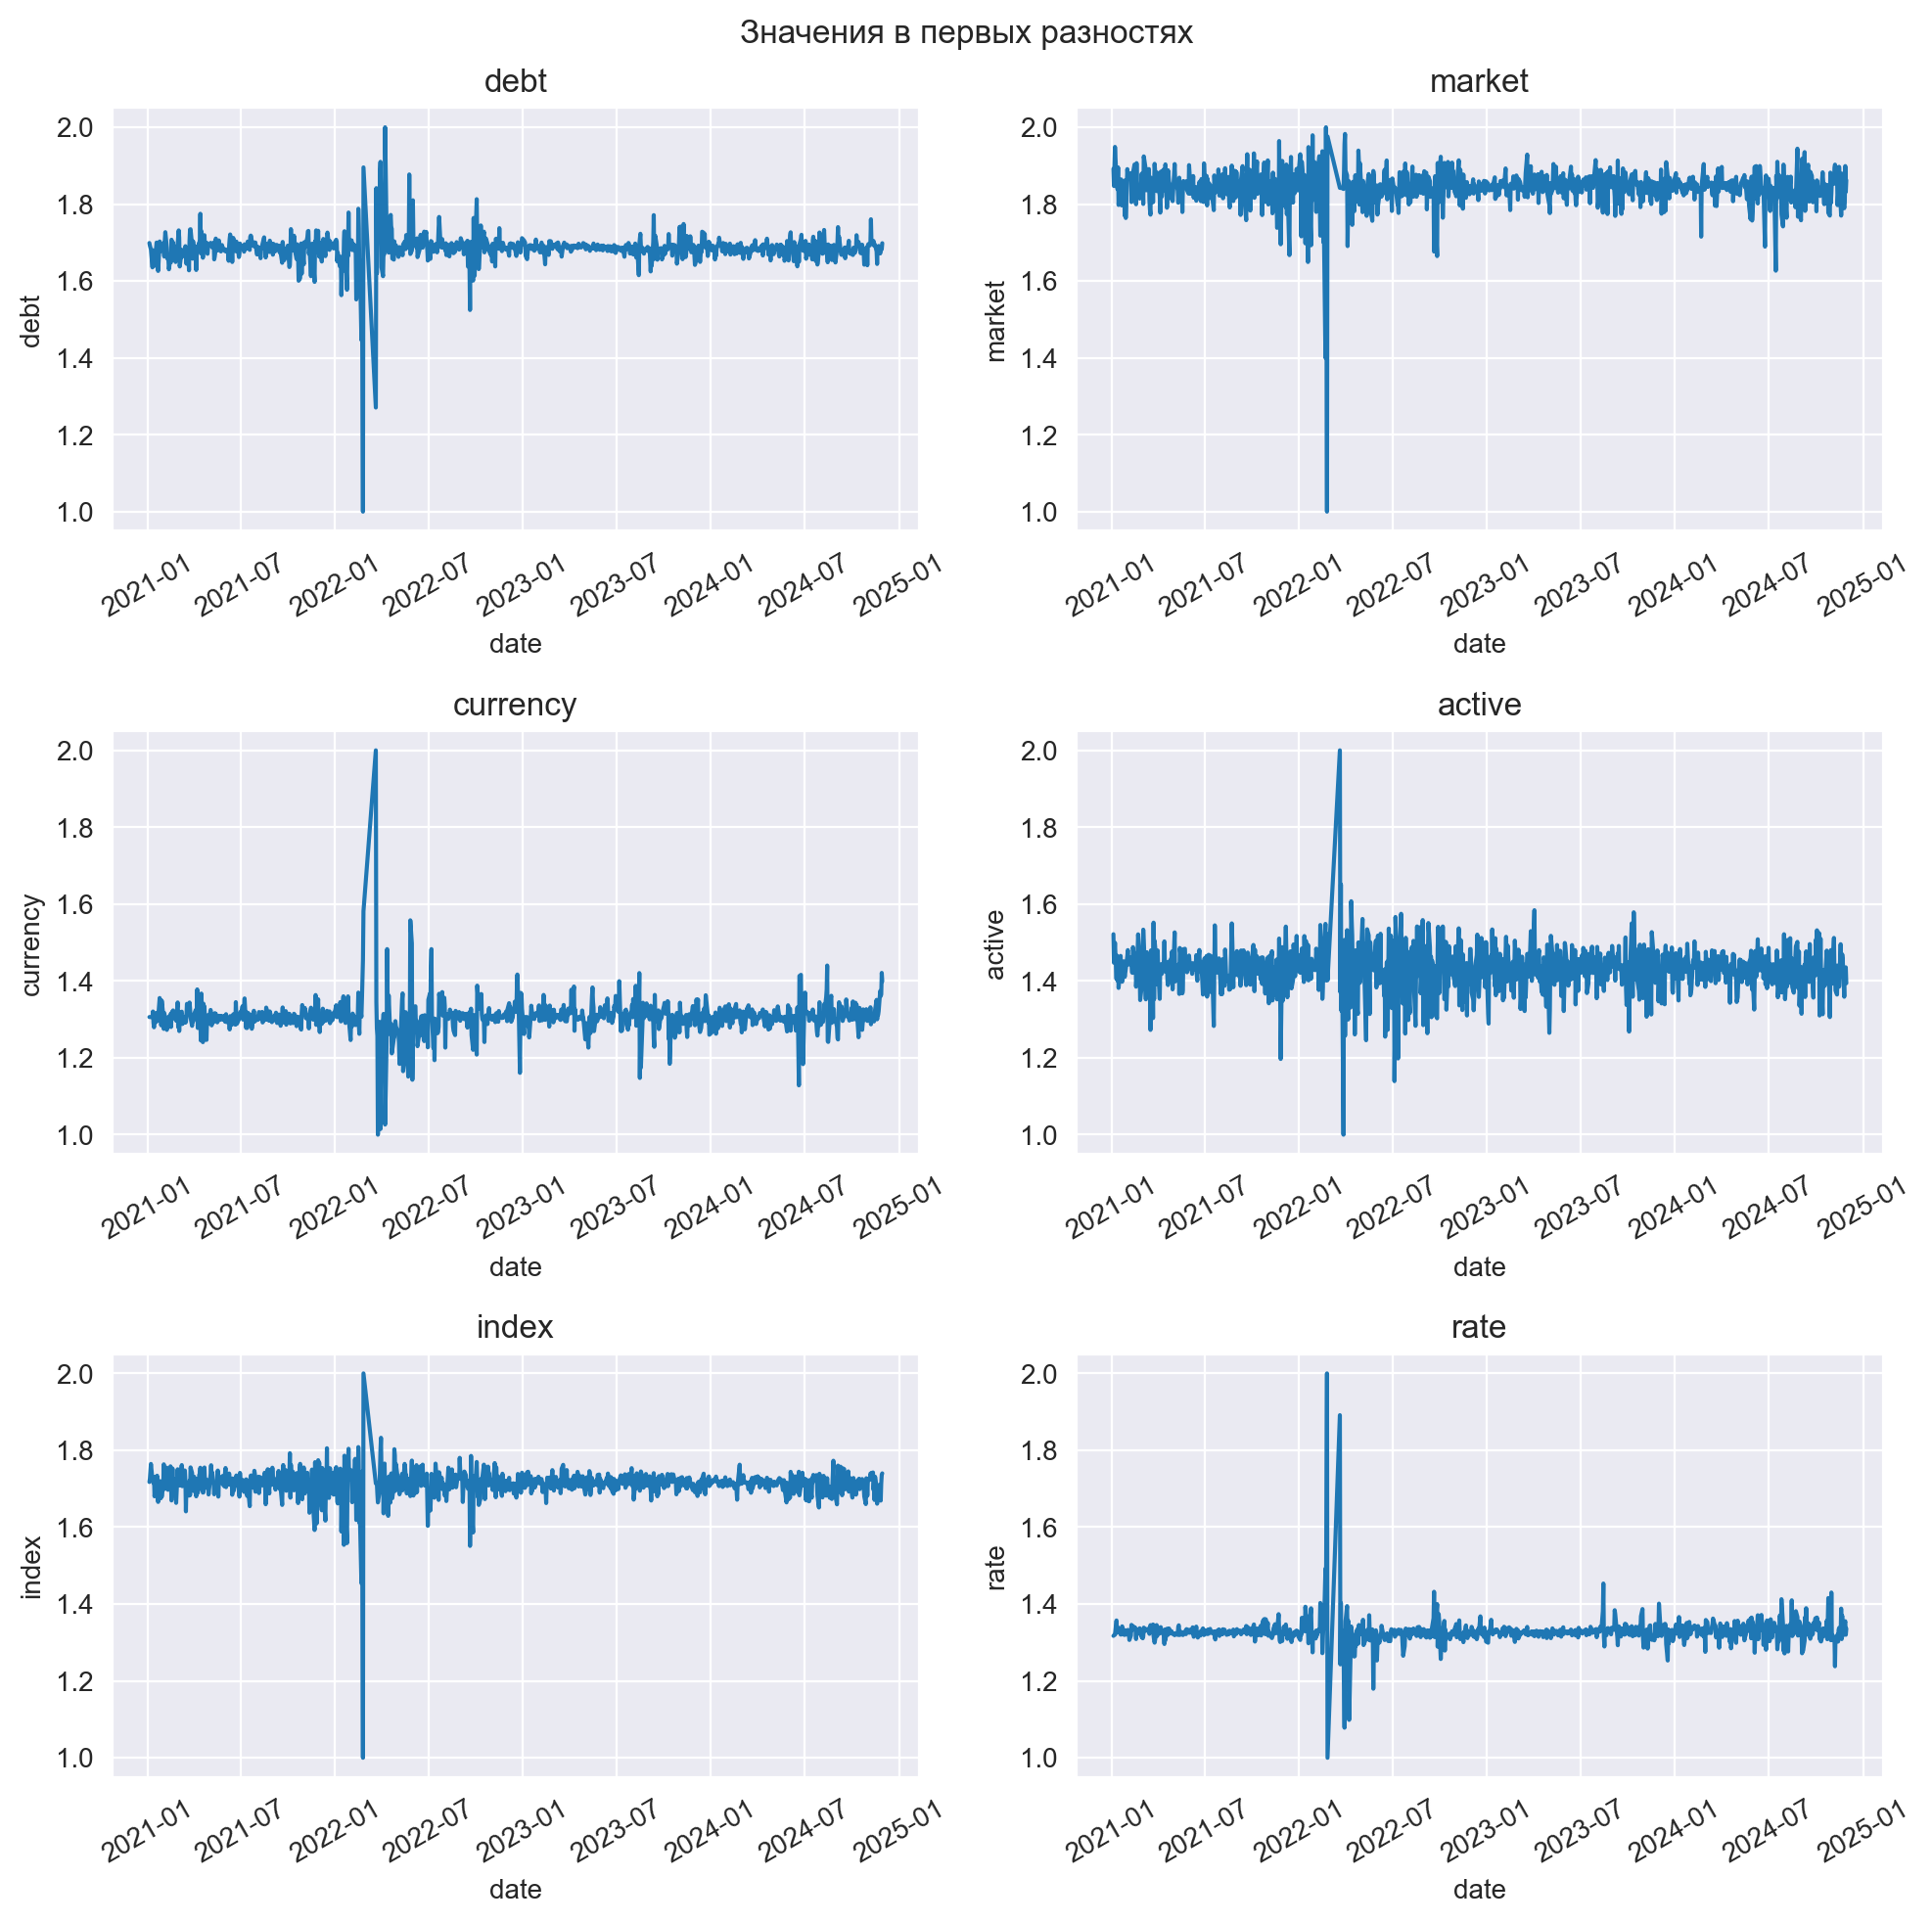

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.lineplot(data=risk_factors_train, x='date', y='debt', ax=axes[0, 0])
axes[0, 0].set_title('debt')
axes[0, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='market', ax=axes[0, 1])
axes[0, 1].set_title('market')
axes[0, 1].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='currency', ax=axes[1, 0])
axes[1, 0].set_title('currency')
axes[1, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='active', ax=axes[1, 1])
axes[1, 1].set_title('active')
axes[1, 1].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='index', ax=axes[2, 0])
axes[2, 0].set_title('index')
axes[2, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=risk_factors_train, x='date', y='rate', ax=axes[2, 1])
axes[2, 1].set_title('rate')
axes[2, 1].tick_params(axis='x', rotation=30)

plt.suptitle('Значения в первых разностях')
plt.tight_layout()
plt.show()

### Симуляционные модели

#### Формирование зависимости между приращениями

Для этого зададим ковариационную матрицу с помощью разложения Холецкого.

$\Sigma = LL^T$, где L - нижнетреугольная матрица с неотрицптельными коэффициентами, $\Sigma$ - заданная ковариционная матрица.

In [20]:
np.random.seed(42) # смысл жизни
N = 10000 # шагов симуляции
STEP = 1e-4

Text(0.5, 1.0, 'Матрица корреляций для PCA факторов')

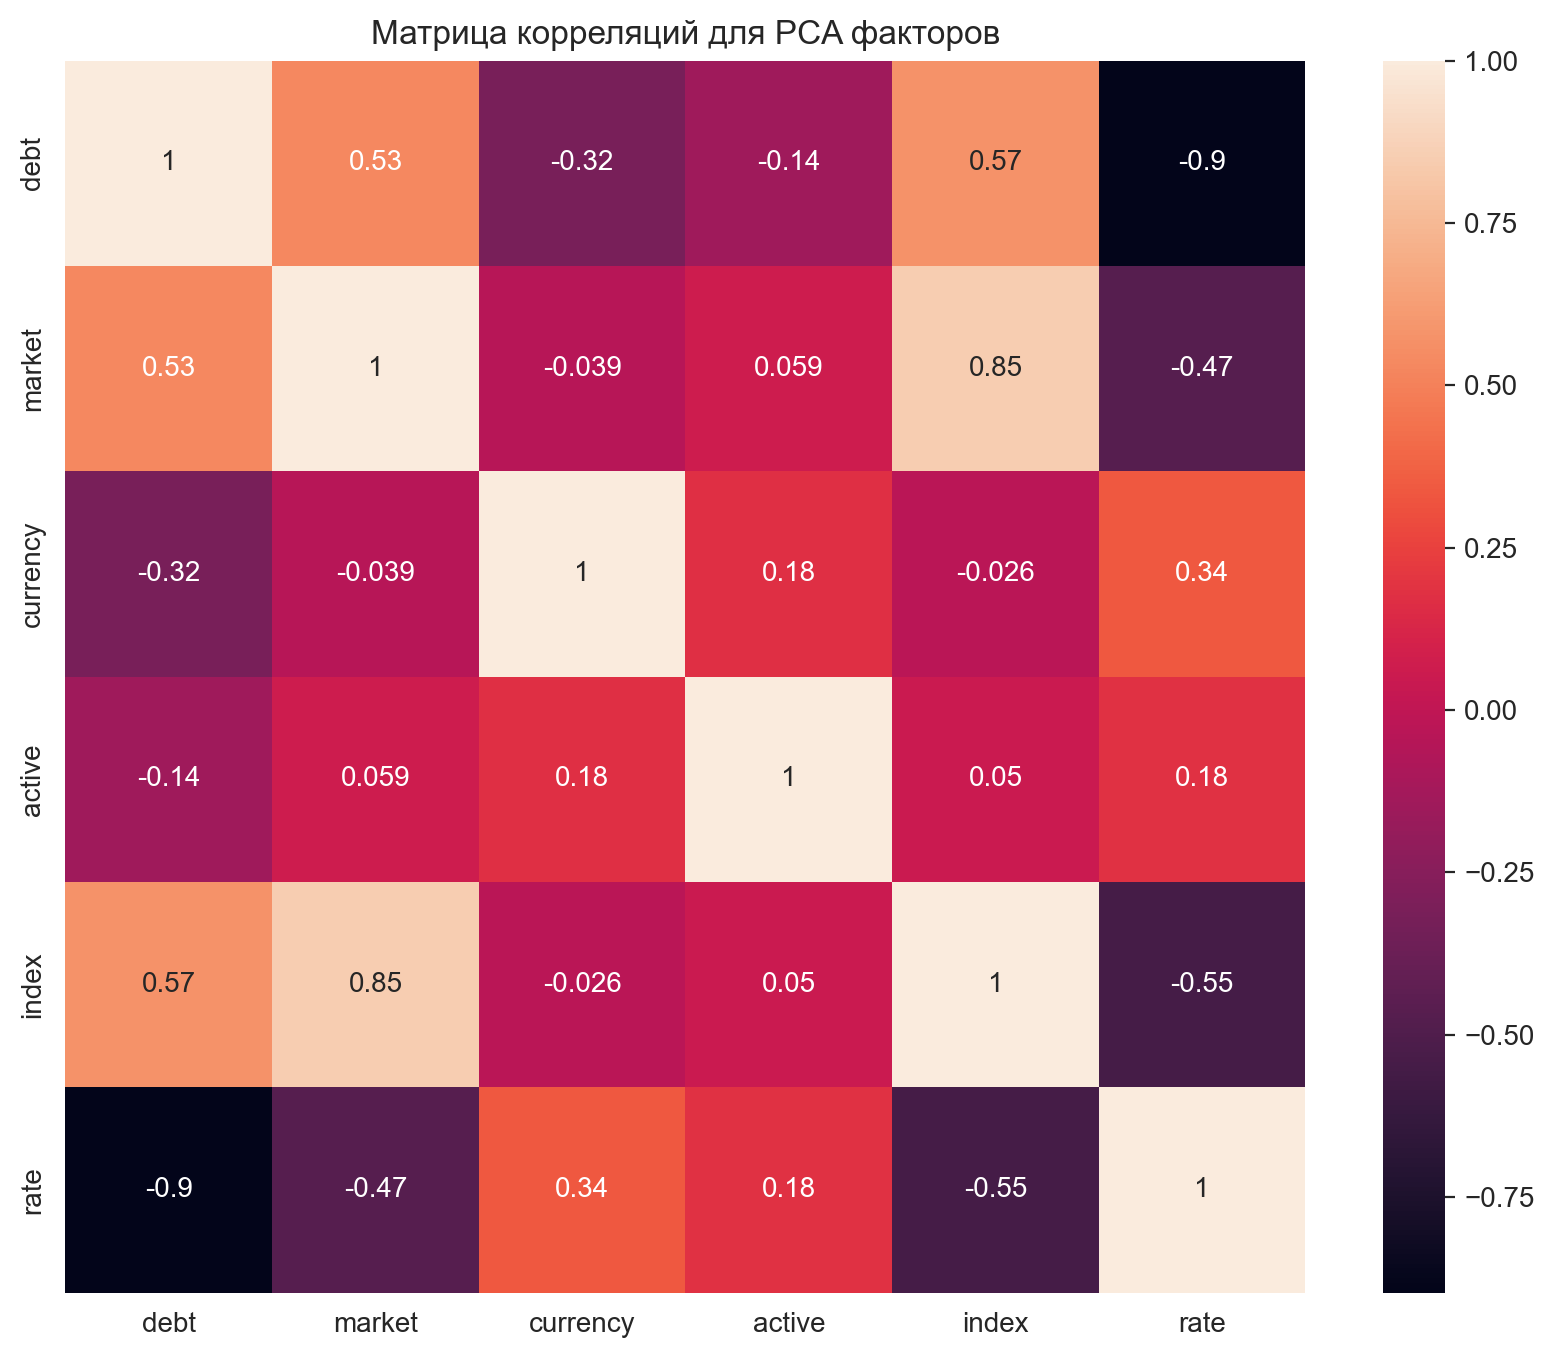

In [21]:
corr_matrix = risk_factors_train.corr().loc[factor_cols, factor_cols]

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True)
plt.title("Матрица корреляций для PCA факторов")

In [22]:
L = np.linalg.cholesky(corr_matrix)

def generate_delta(corr_matrix:np.array, n:int) -> list[np.array]:
    """
    Генерация скоррелированных приращений

    Args:
        corr_matrix (np.array): требуемая корреляционная матрица 
        n (int): кол-во шагов симуляций

    Retutns:
        delta_list (list[np.array]):
    """
    L = np.linalg.cholesky(corr_matrix)
    n_factor = int(corr_matrix.shape[0])

    dist_list = []
    for i in range(n_factor):
        std_dist = np.random.randn(n)
        dist_list.append(std_dist)


    deltas_matrix_independent = np.array(np.vstack(dist_list))
    deltas_matrix_dependent = L @ deltas_matrix_independent

    delta_list = []
    for i in range(n_factor):
        dw = deltas_matrix_dependent[i]
        delta_list.append(dw)

    delta_matrix = np.array(delta_list).T

    return delta_matrix

In [23]:
deltas_matrix_dependent = generate_delta(corr_matrix, N)
delta_df = pd.DataFrame(deltas_matrix_dependent, columns=factor_cols)
delta_corr = delta_df.corr()

Text(0.5, 1.0, 'Матрица корреляций для приращений')

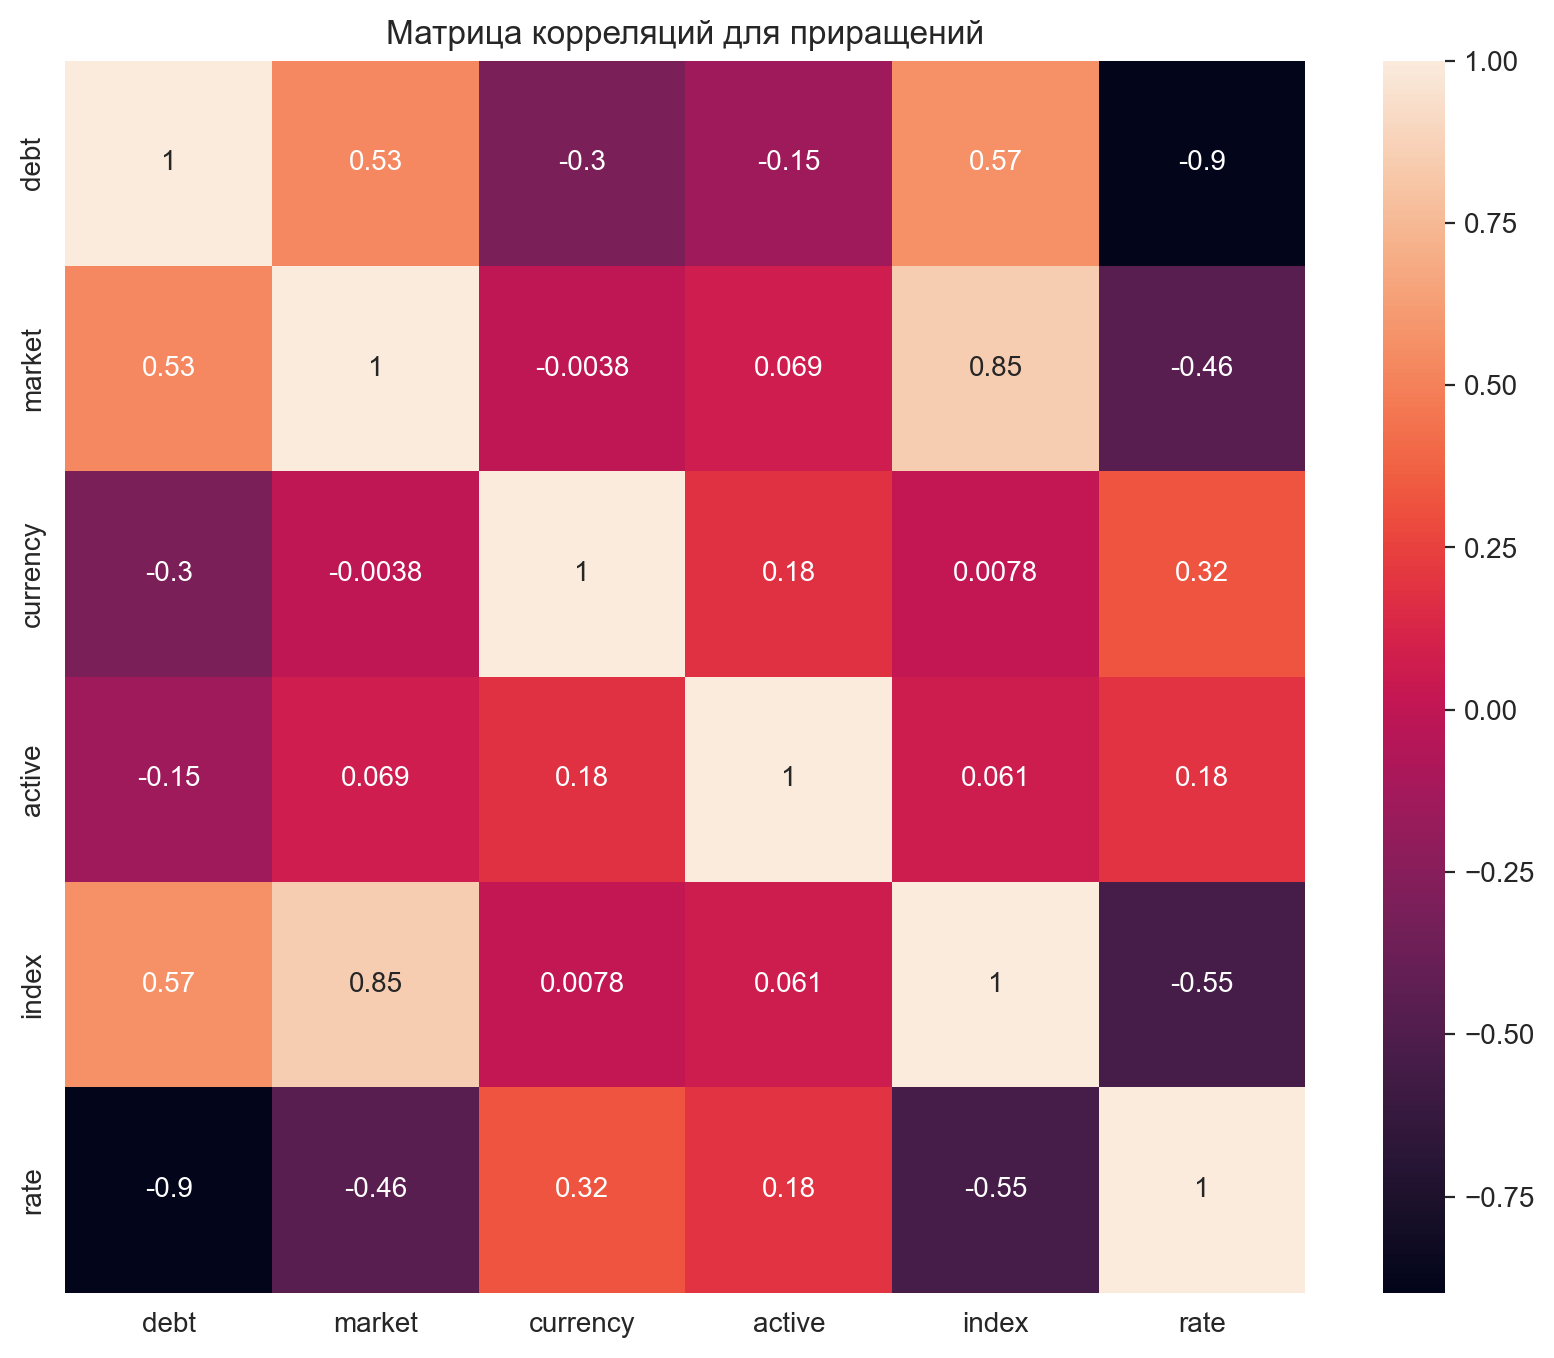

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(delta_corr, annot=True)
plt.title("Матрица корреляций для приращений") # совпадает с истинной

In [25]:
#  симуляция тестового периода
N = len(test_data)

deltas_matrix_dependent = generate_delta(corr_matrix, N)
delta_df = pd.DataFrame(deltas_matrix_dependent, columns=factor_cols)

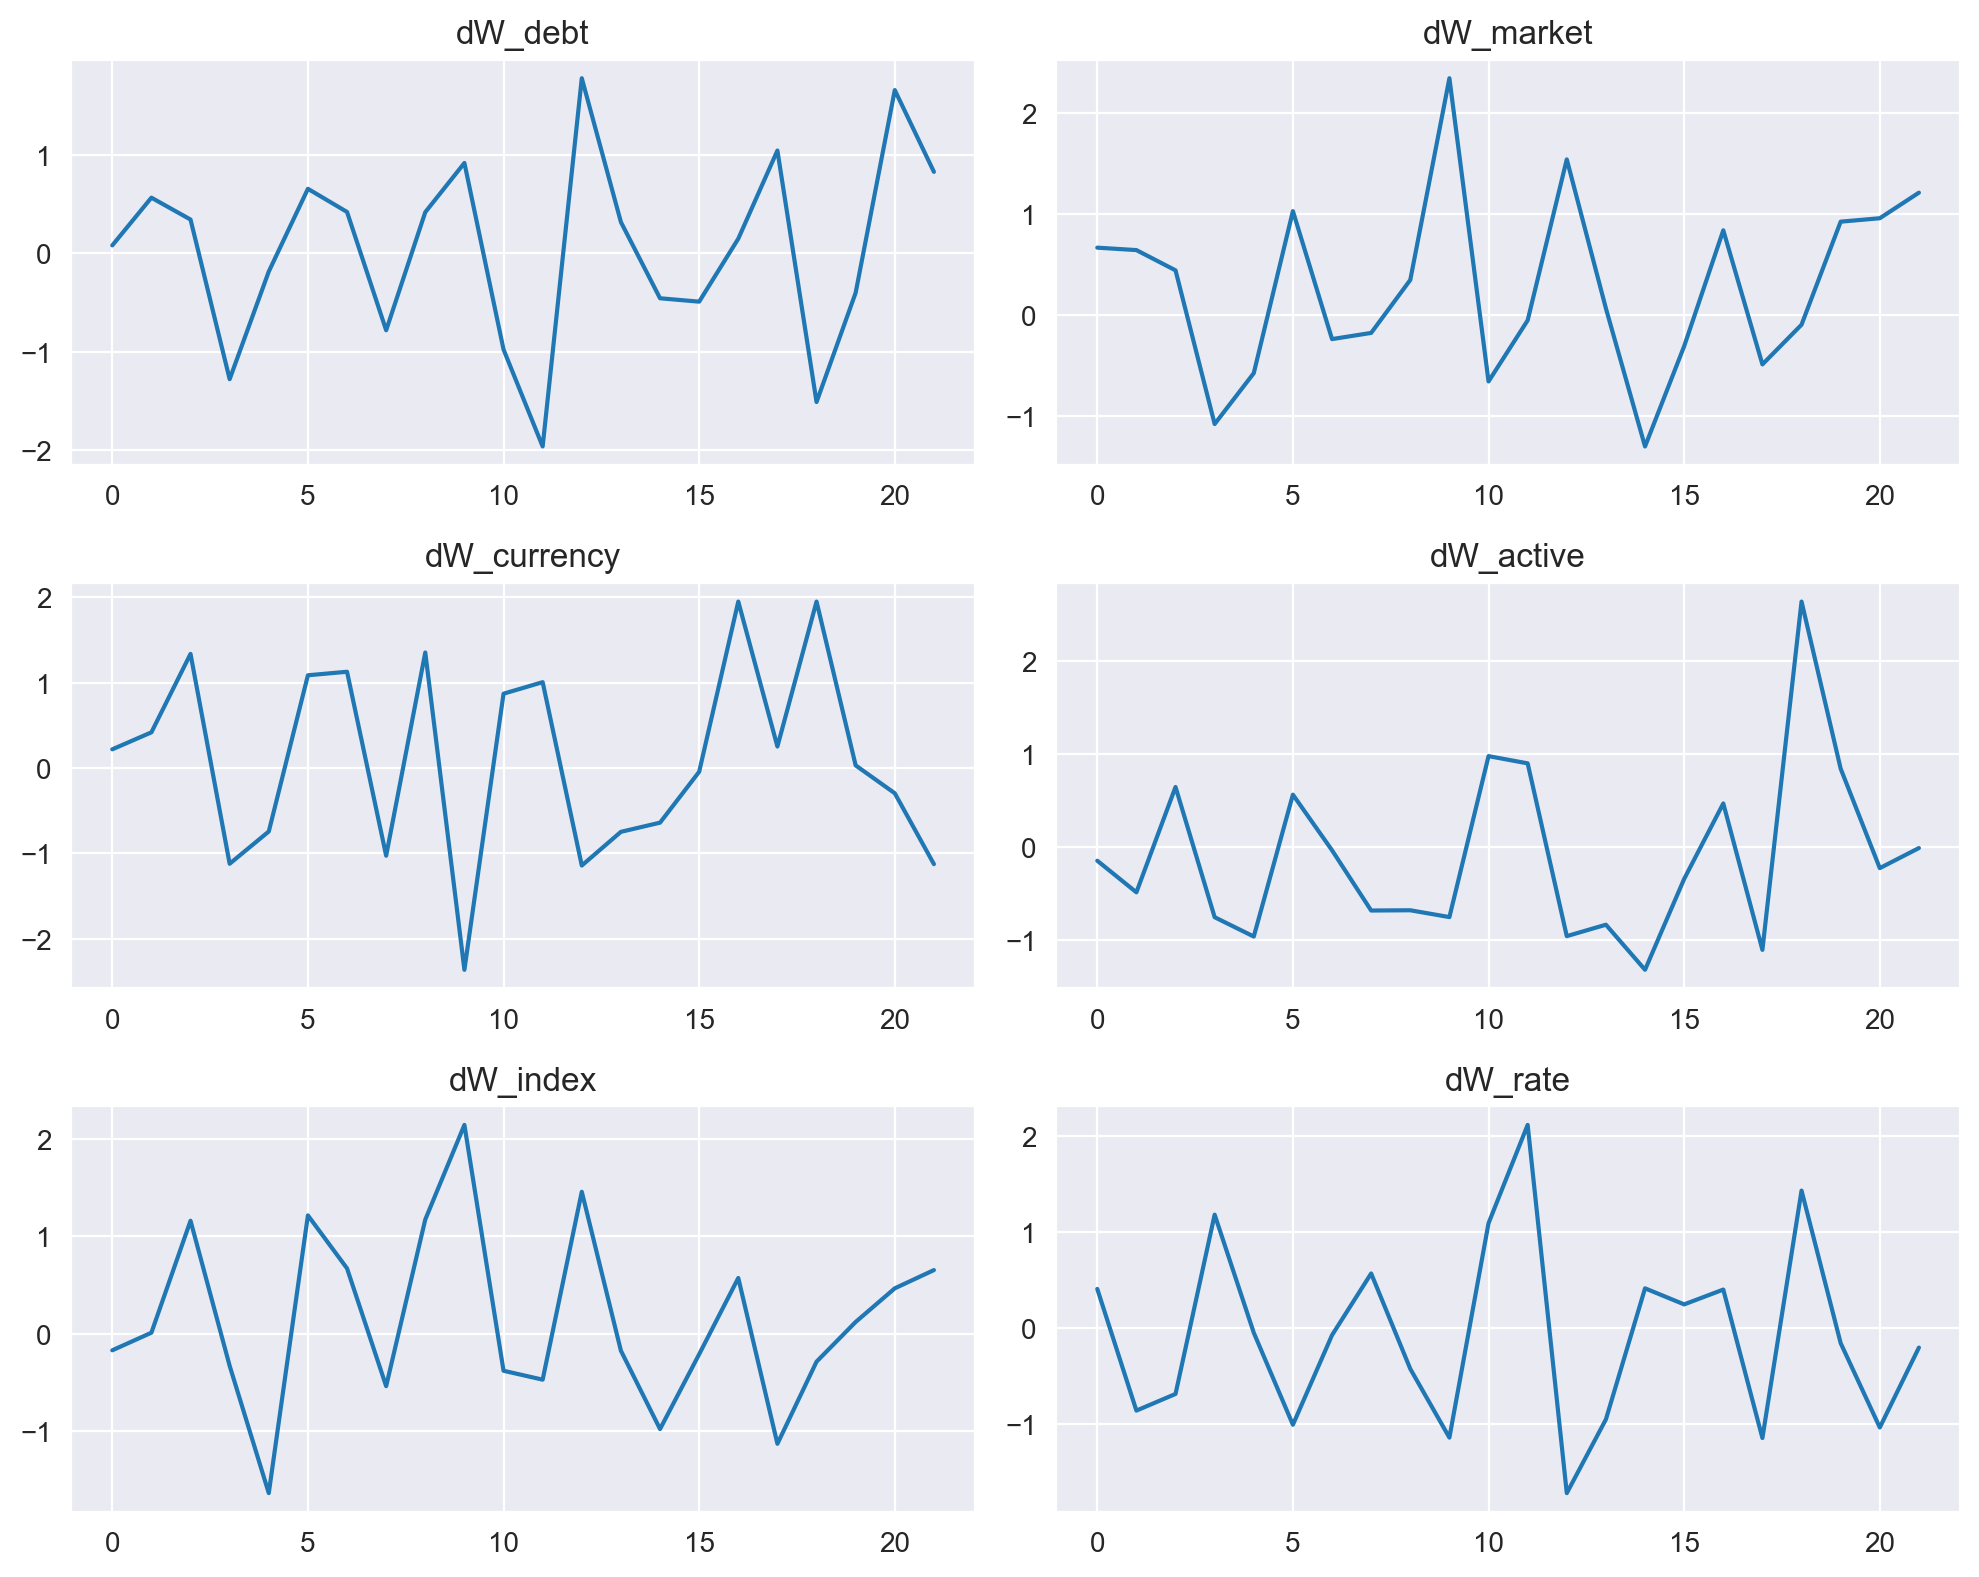

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

sns.lineplot(x=list(range(N)), y=deltas_matrix_dependent[:,0], ax=axes[0, 0])
axes[0, 0].set_title('dW_debt')

sns.lineplot(x=list(range(N)), y=deltas_matrix_dependent[:,1], ax=axes[0, 1])
axes[0, 1].set_title('dW_market')

sns.lineplot(x=list(range(N)), y=deltas_matrix_dependent[:,2], ax=axes[1, 0])
axes[1, 0].set_title('dW_currency')

sns.lineplot(x=list(range(N)), y=deltas_matrix_dependent[:,3], ax=axes[1, 1])
axes[1, 1].set_title('dW_active')

sns.lineplot(x=list(range(N)), y=deltas_matrix_dependent[:,4], ax=axes[2, 0])
axes[2, 0].set_title('dW_index')

sns.lineplot(x=list(range(N)), y=deltas_matrix_dependent[:,5], ax=axes[2, 1])
axes[2, 1].set_title('dW_rate')

plt.tight_layout()
plt.show()

Возьмем SIR модель: 

$dX_t = \kappa (\theta - X_t) \, dt + \sigma \sqrt{X_t} \, dW_t$

$\kappa \ge 0, \sigma \ge 0, \theta \ge 0, 2 \kappa \theta \ge \sigma^2$

In [27]:
def simulate_cir_process(kappa:float, theta:float, sigma:float, x0:float, dW:np.array) -> np.array:
    """
    Симуляция CIR-процесса по формуле Эйлера.

    Args:
        kappa (float): сила возврату к среднему
        theta (float): среднее
        sigma (float): стандартное откланенеи
        x0 (float): начальная точка
        dW (np.array): приращения

    Returns:
        x (np.array): симуляция ряда
    """
    n = len(dW) - 2
    x = np.zeros(n + 1)
    x[0] = x0
    for t in range(n):
        x[t+1] = x[t] + kappa * (theta - x[t]) * STEP + sigma * np.sqrt(max(x[t], 0)) * dW[t]
    return x

Для калибровки CIR модели воспользуемся OLS. Для этого дискретизируем модель:

$dr(t) = (\theta - r(t))dt + \sigma\sqrt{r_t}dW_t$

Распишем схему Эйлера-Мураямы:

$r_{t+\delta t} - r_t = k(\theta - r_t)(t+\delta t-t) + \sigma \sqrt{r_t}(W_{t+\delta t}-W_t),$

где $W_{t+\delta t}-W_t \sim N(0,\delta t)$

Перепишем в следующем ввиде:

$\frac{{r_{t+\delta t} - r_t}}{{\sqrt{r_t}}} = \frac{k\theta}{\sqrt{r_t}} - k\sqrt{r_t} + \sigma \varepsilon, \varepsilon \sim N(0,\delta t)$.

Можем предстваить данное уравненеи, как уравнение линейной регрессии:

$y_i = \beta_1 z_{1,i} + \beta_2 z_{2,i} + \epsilon_i, где$

$y_i = \frac{{r_{t+\delta t} - r_t}}{{\sqrt{r_t}}}$

$\beta_1 = k \theta$
$\beta_2 = - k$

$z_{1,i} = \frac{1}{\sqrt{r_t}}$
$z_{2,i} = \sqrt{r_t}$

$\epsilon_i = \sigma \varepsilon$

Тогда искомые параметры будут находиться по формуле:

$\hat{k} = -\hat{\beta_2}$

$\hat{\theta} = \frac{\hat{\beta_1}}{\hat{k}} $

$\hat{\sigma^2} = \hat{Var(\epsilon)} $

In [28]:
def get_params(history:np.array) -> tuple[float, float, float]:
    """
    Получаем наилучшие параметры для симуляции

    Args:
        history (np.array): исторические данные
    Returns:
        kappa (float): сила возврату к среднему
        theta (float): среднее
        sigma (float): стандартное откланенеи
    """
    train = history[:-1]
    shifted_train = history[1:] + 1e-2

    y = (train - shifted_train) / np.sqrt(shifted_train)
    z1 = 1 / np.sqrt(shifted_train)
    z2 = np.sqrt(shifted_train)

    features = pd.DataFrame({'z1':z1, 'z2':z2})
    target = pd.DataFrame({'y':y})

    model = LinearRegression(fit_intercept=False)
    model.fit(features, target)

    y_pred = model.predict(features)
    residuals = target - y_pred
    b1 = model.coef_[0][0]
    b2 = model.coef_[0][1]
    k = -b2
    theta = b1/k
    sigma = np.std(residuals, axis=0).iloc[0]
    return k, theta, sigma

In [29]:
np.random.seed(42)
deltas_matrix_dependent = generate_delta(corr_matrix, n=N)

para_dist = {}
for i, name in enumerate(factor_cols):
    dW = deltas_matrix_dependent[:, i]
    history = risk_factors_train[risk_factors_train['date'].dt.year >= 2024].iloc[:, i+1].to_numpy()
    k, theta, sigma = get_params(history)
    para_dist[name] = {
        "k":k, 
        "theta":theta, 
        "sigma":sigma
    }
para_dist

{'debt': {'k': 0.8009645417957023,
  'theta': 1.681904199777794,
  'sigma': 0.013294775622173184},
 'market': {'k': 0.9809711272236102,
  'theta': 1.8396786779564132,
  'sigma': 0.027715619708404964},
 'currency': {'k': 0.7558809613116333,
  'theta': 1.305458732317729,
  'sigma': 0.02573853816083236},
 'active': {'k': 1.0343369944914274,
  'theta': 1.428491895459338,
  'sigma': 0.034544553931688364},
 'index': {'k': 0.8356497031902955,
  'theta': 1.7096638134826496,
  'sigma': 0.014888347682419008},
 'rate': {'k': 0.8790131646950518,
  'theta': 1.329792369721774,
  'sigma': 0.021661522228095365}}

In [30]:
start_date = '2024-12-03'
x0_dict = risk_factors_test[risk_factors_test['date'] == start_date].to_dict(orient='records')[0]

In [31]:
np.random.seed(42)

simulations = {k: [] for k in factor_cols}

for i in tqdm(range(10000)):
    deltas_matrix_dependent = generate_delta(corr_matrix, N)
    delta_df = pd.DataFrame(deltas_matrix_dependent, columns=factor_cols)

    for name in factor_cols:
        k, theta, sigma = para_dist[name].values()
        sim = simulate_cir_process(k, theta, sigma, x0_dict[name], delta_df[name])
        simulations[name].append(sim)

100%|██████████| 10000/10000 [00:10<00:00, 952.81it/s]


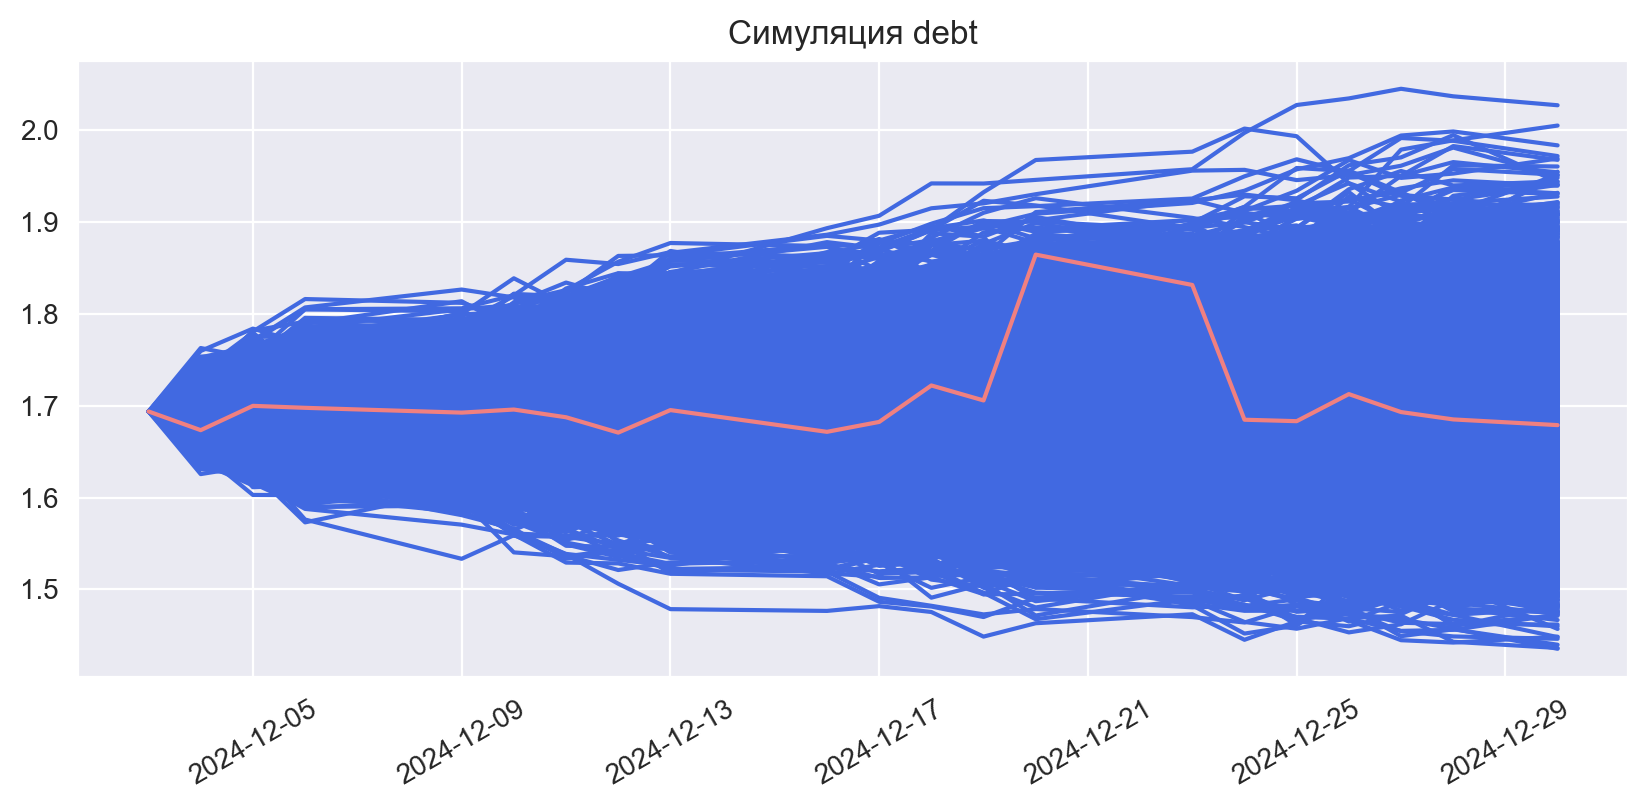

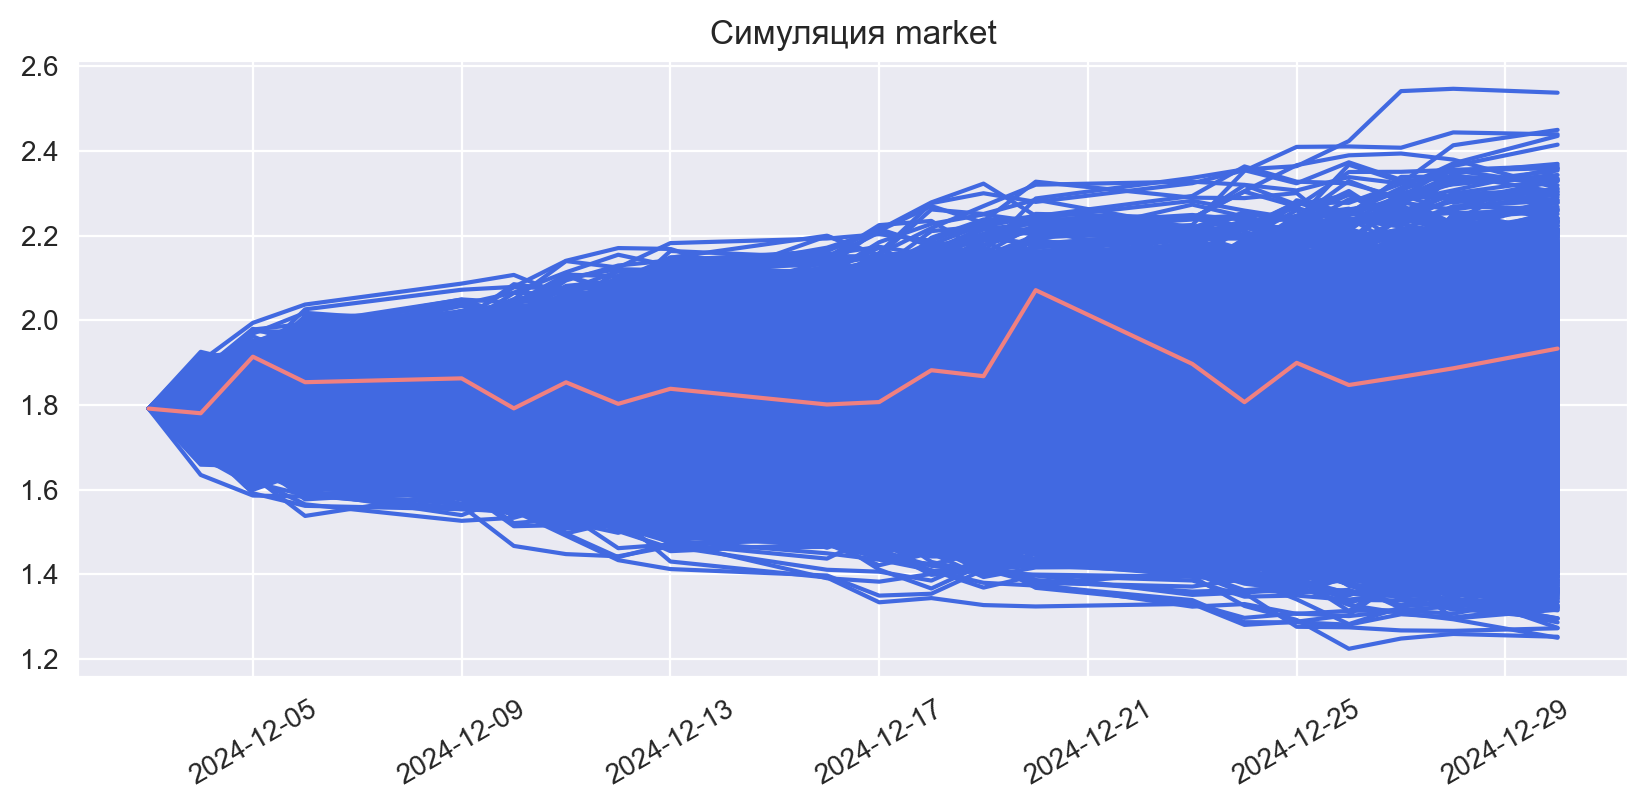

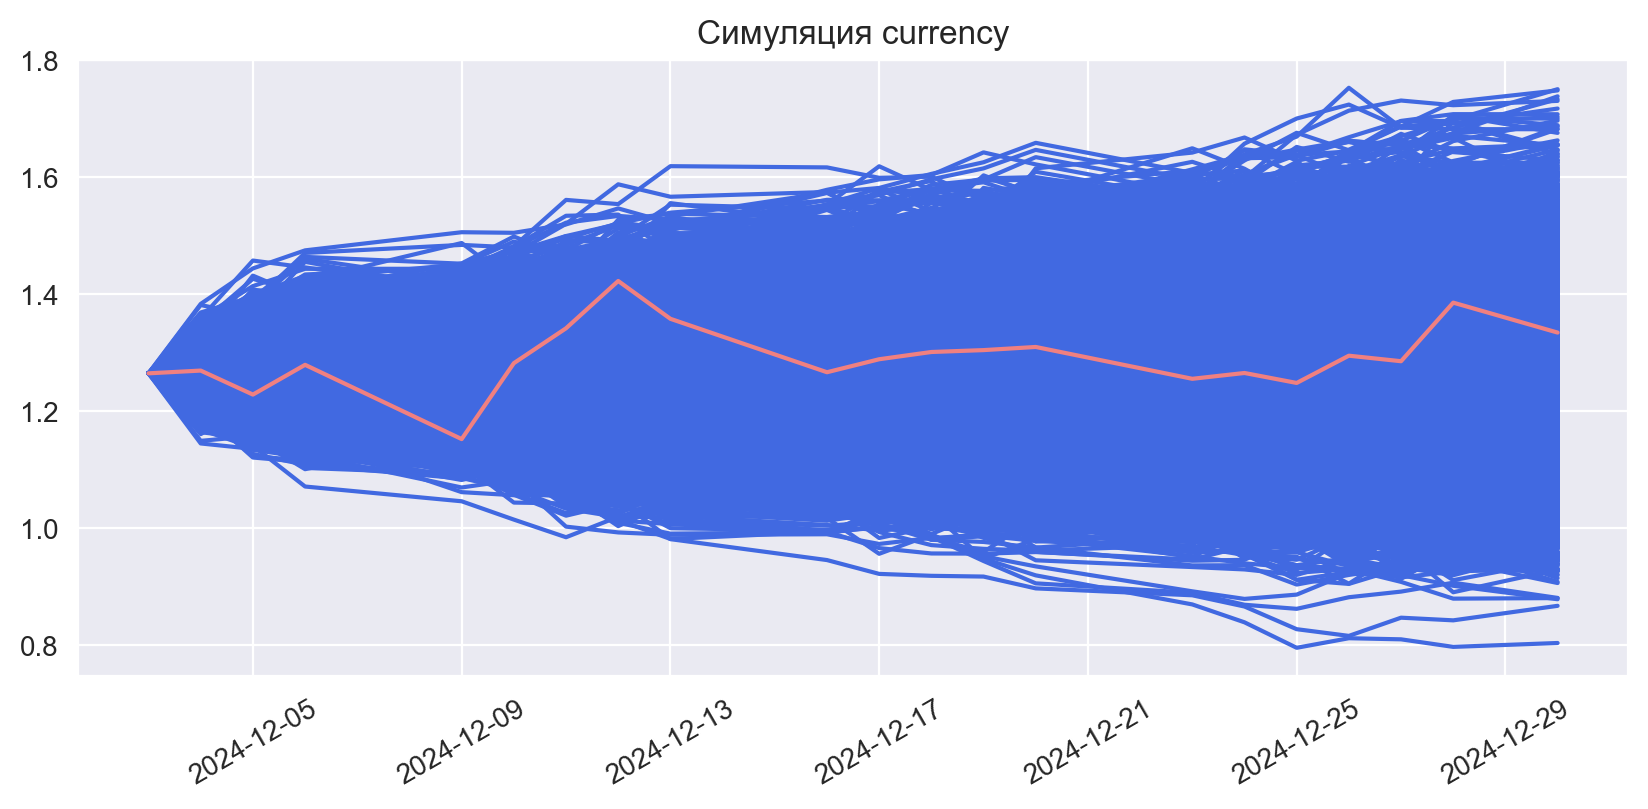

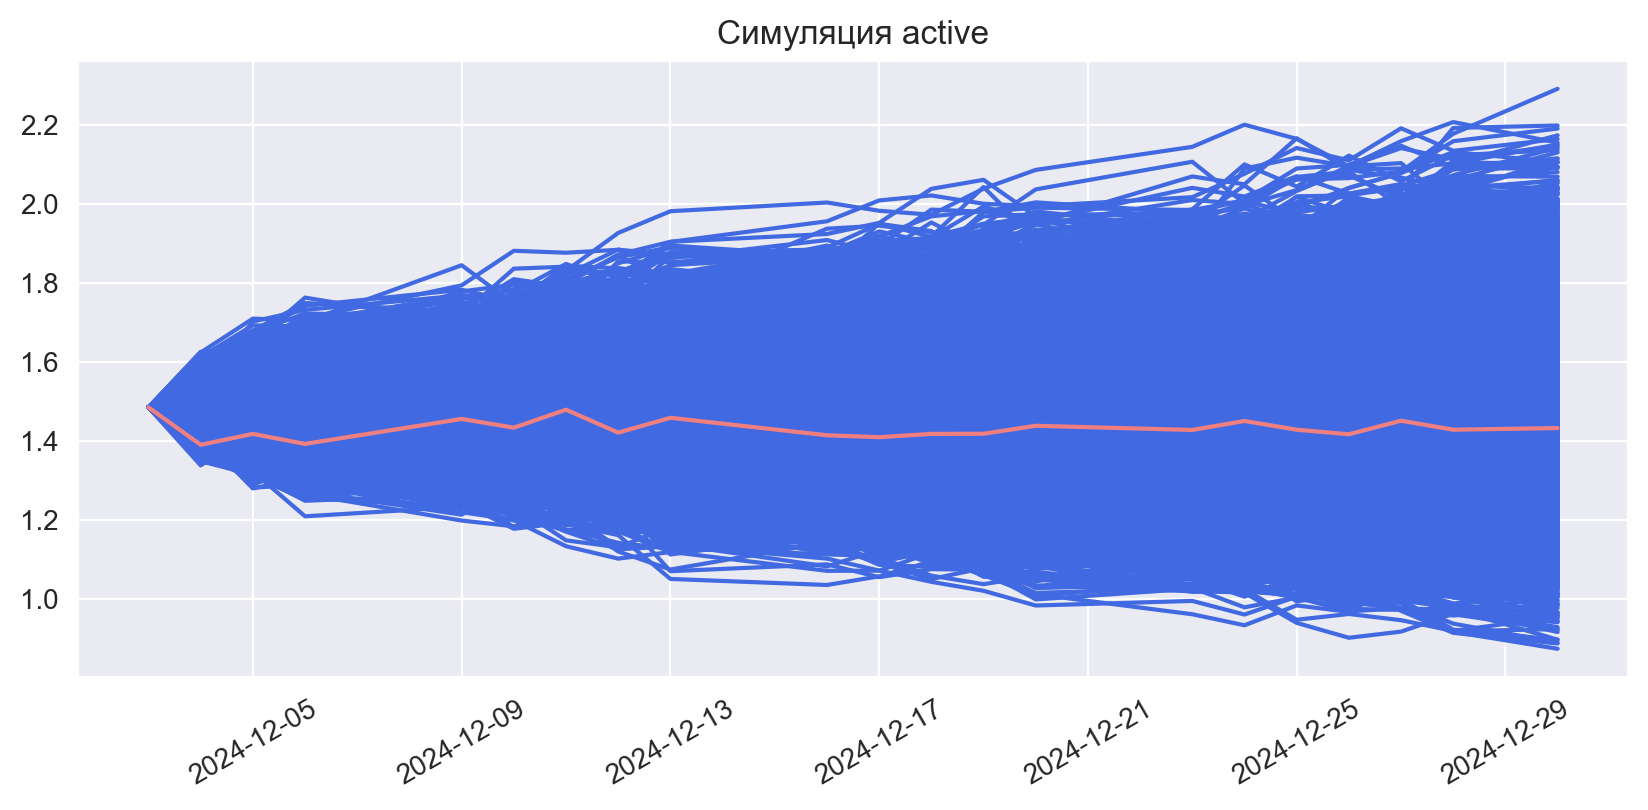

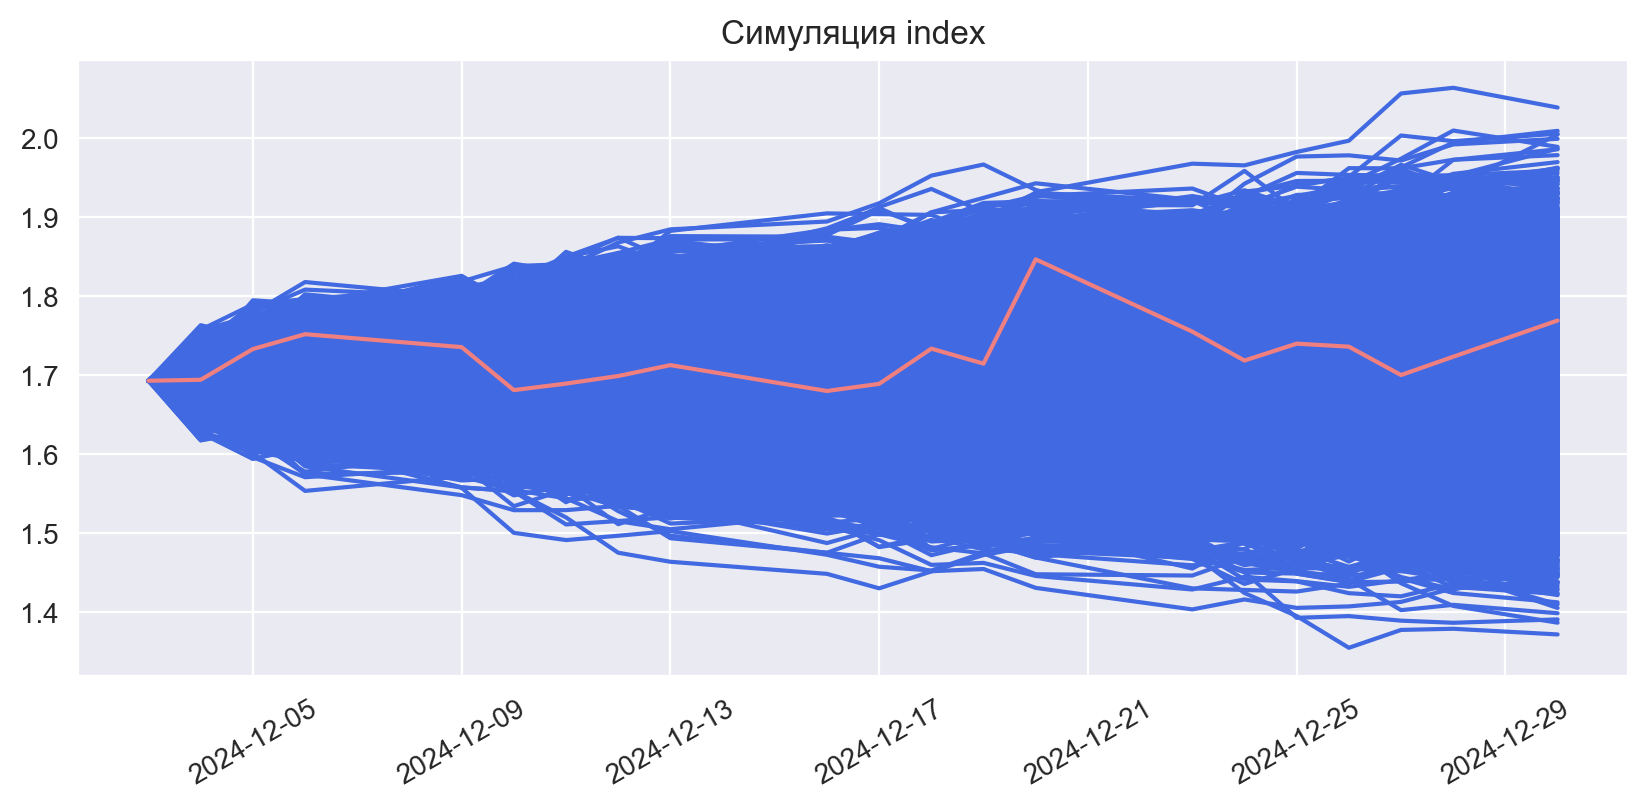

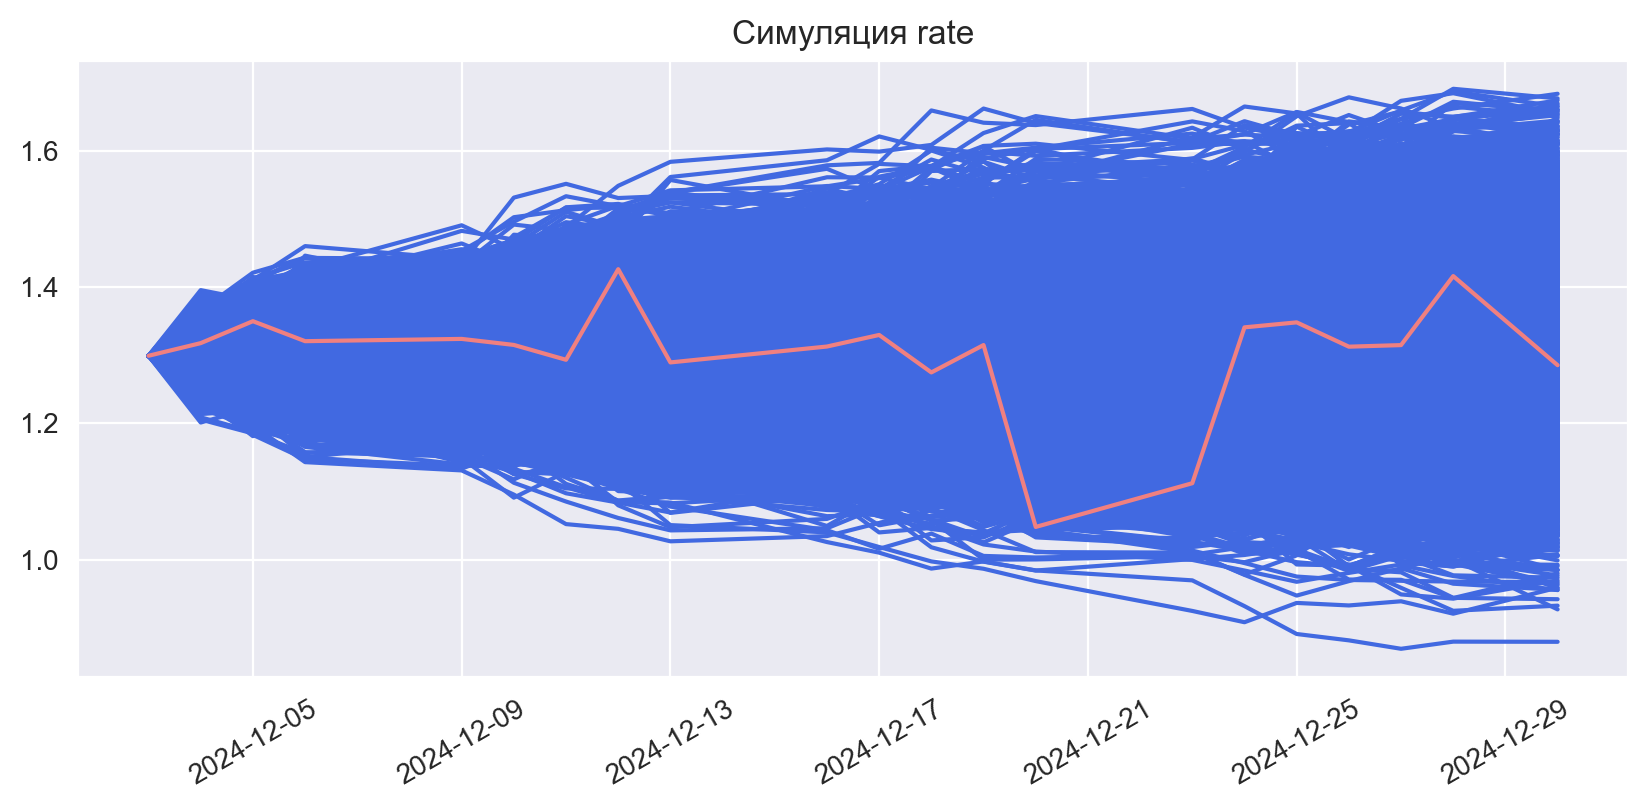

In [41]:
for name in factor_cols:
    plt.figure(figsize=(10,4))
    for sim in simulations[name]:
        plt.plot(risk_factors_test['date'], sim, c='royalblue')

    plt.plot(risk_factors_test['date'], risk_factors_test[name].to_list(), c='lightcoral')
    plt.title(f'Симуляция {name}')
    plt.xticks(rotation=30)
    plt.show()

### Справедливая стоимость

In [31]:
X_train = risk_factors_train[risk_factors_train['date'].dt.year >= 2024].iloc[:,1:]
y_train = train_data[train_data['begin'].dt.year >= 2024].iloc[:,1:]

X_test = risk_factors_test[risk_factors_test['date'].dt.year >= 2024].iloc[:,1:]
y_test = test_data[test_data['begin'].dt.year >= 2024].iloc[1:,1:]

models = {}

#### Акции

In [32]:
for share in market_set:
    model = LinearRegression()
    model.fit(X_train, y_train[share])
    models[share] = model
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test[share], prediction)
    mape = mean_absolute_percentage_error(y_test[share], prediction)

    print(f"{share} test| MAE: {round(mae, 4)} | MAPE: {round(mape, 4)}\n"+"-"*50)

LKOH test| MAE: 351.0955 | MAPE: 0.0525
--------------------------------------------------
AFLT test| MAE: 3.5871 | MAPE: 0.067
--------------------------------------------------
GMKN test| MAE: 32.1614 | MAPE: 0.31
--------------------------------------------------
NVTK test| MAE: 313.0139 | MAPE: 0.3722
--------------------------------------------------
SBER test| MAE: 44.2216 | MAPE: 0.1868
--------------------------------------------------
AFKS test| MAE: 7.3609 | MAPE: 0.5834
--------------------------------------------------
CHMF test| MAE: 441.5032 | MAPE: 0.3991
--------------------------------------------------
ROSN test| MAE: 48.0451 | MAPE: 0.0941
--------------------------------------------------
VTBR test| MAE: 34.829 | MAPE: 0.5036
--------------------------------------------------
RASP test| MAE: 105.5993 | MAPE: 0.4321
--------------------------------------------------


### Валюта

In [33]:
for curr in currency_set:
    model = LinearRegression()
    model.fit(X_train, y_train[curr])
    models[curr] = model
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test[curr], prediction)
    mape = mean_absolute_percentage_error(y_test[curr], prediction)

    print(f"{curr} test| MAE: {round(mae, 4)} | MAPE: {round(mape, 4)}\n"+"-"*50)

euro_cb test| MAE: 9.1665 | MAPE: 0.0847
--------------------------------------------------
usd_cb test| MAE: 11.6677 | MAPE: 0.1137
--------------------------------------------------


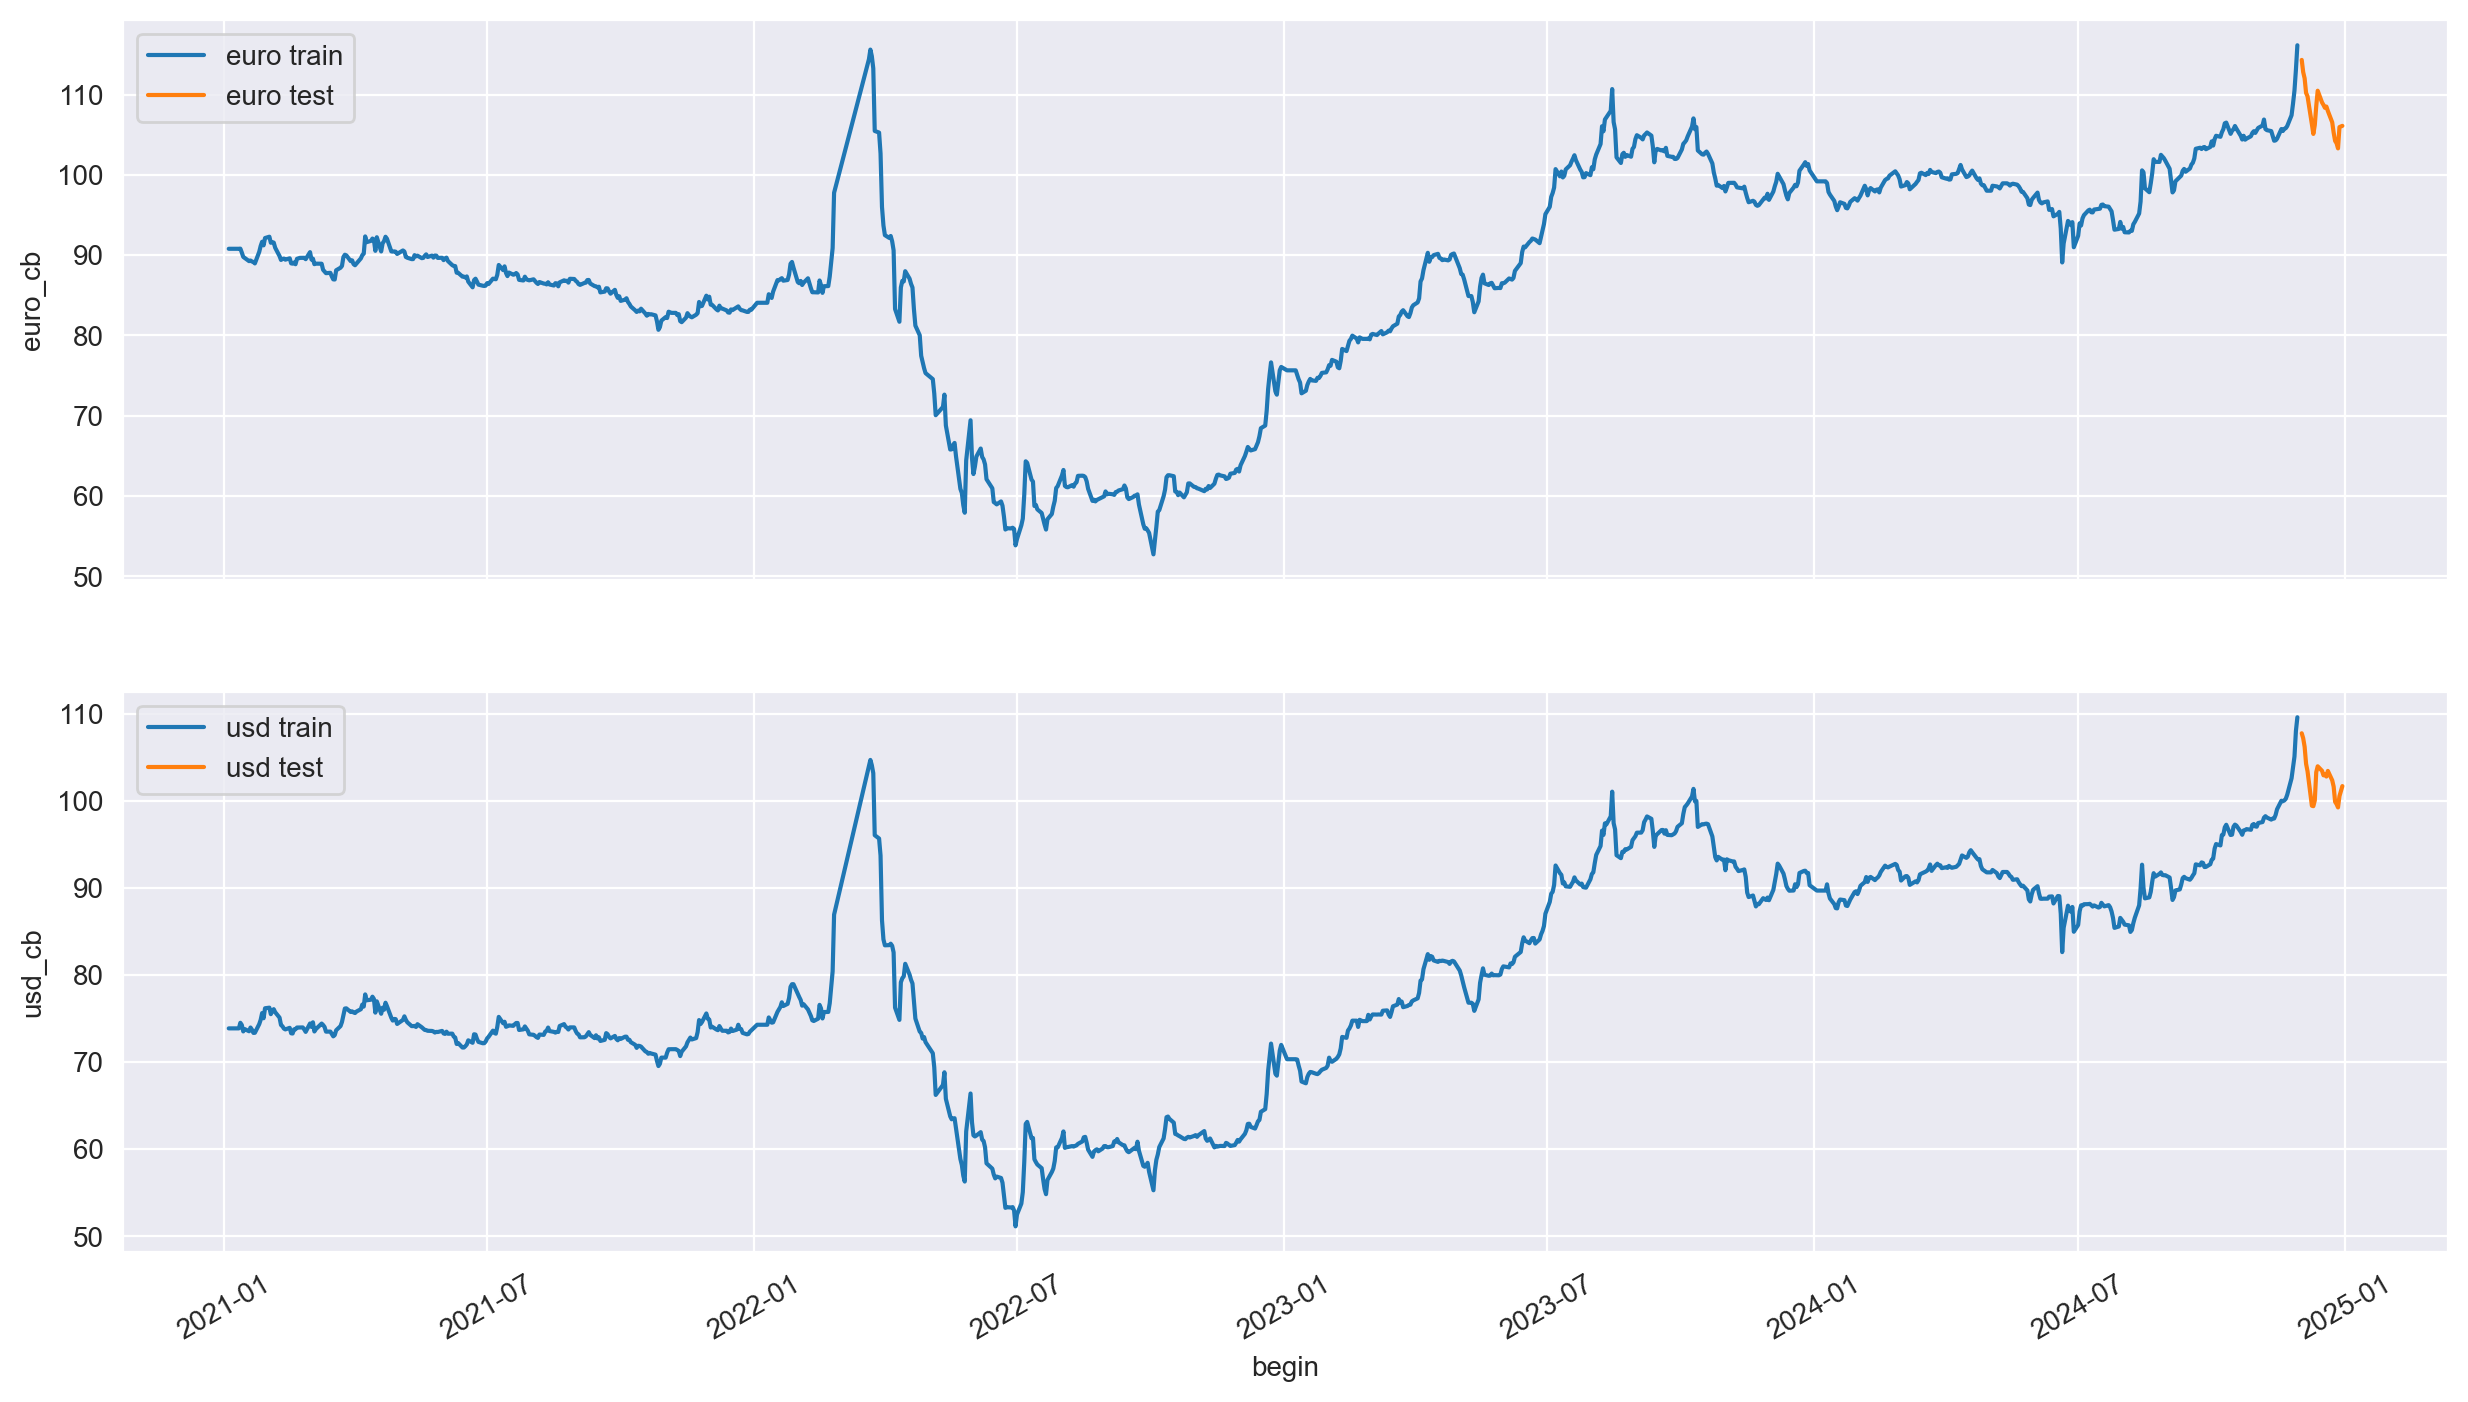

In [69]:
fig, ax = plt.subplots(2, figsize=(15, 8), sharex=True)

sns.lineplot(data=train_data, x='begin', y='euro_cb', ax=ax[0], label='euro train')
sns.lineplot(data=test_data, x='begin', y='euro_cb', ax=ax[0], label='euro test')
ax[0].tick_params(axis='x', rotation=30)

sns.lineplot(data=train_data, x='begin', y='usd_cb', ax=ax[1], label='usd train')
sns.lineplot(data=test_data, x='begin', y='usd_cb', ax=ax[1], label='usd test')
ax[1].tick_params(axis='x', rotation=30)

### Облигации

In [36]:
for bond in debt_set:
    model = LinearRegression()
    model.fit(X_train, y_train[bond])
    prediction = model.predict(X_test)
    models[bond] = model
    mae = mean_absolute_error(y_test[bond], prediction)
    mape = mean_absolute_percentage_error(y_test[bond], prediction)

    print(f"{bond} test| MAE: {round(mae, 4)} | MAPE: {round(mape, 4)}\n"+"-"*50)

SU26207RMFS9 test| MAE: 4.8856 | MAPE: 0.0608
--------------------------------------------------
SU26225RMFS1 test| MAE: 7.3744 | MAPE: 0.1286
--------------------------------------------------
SU26229RMFS3 test| MAE: 1.4234 | MAPE: 0.0158
--------------------------------------------------
SU26233RMFS5 test| MAE: 3.7484 | MAPE: 0.0713
--------------------------------------------------
SU26235RMFS0 test| MAE: 6.1009 | MAPE: 0.1044
--------------------------------------------------


In [37]:
shares = {
    'LKOH':1, 
    'AFLT':1, 
    'GMKN':1, 
    'NVTK':1, 
    'SBER':1, 
    'AFKS':1, 
    'CHMF':1, 
    'ROSN':1, 
    'VTBR':1, 
    'RASP':1, 
    'euro_cb':100, 
    'usd_cb':100, 
    'SU26207RMFS9':10, 
    'SU26225RMFS1':10, 
    'SU26229RMFS3':10, 
    'SU26233RMFS5':10, 
    'SU26235RMFS0':10
}
total = sum(shares.values())
shares = {k : (v / total) for k, v in shares.items()}
shares_df = pd.DataFrame(shares, index=[0])

In [38]:
def predict_value(data:pd.DataFrame, models:dict) -> pd.DataFrame:
    """
    Педсказания значения цен на определенный день

    Args:
        data (pd.DataFrame): данные на интересуюший нас день
        models (dict): сдлварь с можелями предсказаний для конкретных активов

    Returns:
        values_df (pd.DataFrame): таблица с предсказанными ценами 
    """
    values = {}
    for name, model in models.items():
        prediction = model.predict(data)
        values[name] = prediction
    values_df = pd.DataFrame(values)
    return values_df

In [39]:
def get_scenarios_data(simulations:dict, n:int) -> pd.DataFrame:
    """
    Формирует таблицу значений симуляций на определнный день

    Args:
        simulations (dict): результаты симуляций
        n (int): номер дня на который надо получить данные

    Returns:
        data (pd.DataFrame): таблица на требуемый день
    """
    scenarios = {}
    for k, v in simulations.items():
        scenarios[k] = []
        for i in v:
            scenarios[k].append(i[n])
    data = pd.DataFrame(scenarios)
    return data

In [40]:
base_prices = test_data[test_data['begin'] == start_date][shares.keys()]

In [41]:
def draw_count_var_es(loss_profit_list):
  var = np.quantile(loss_profit_list, q=0.01)

  loss_profit_array = np.array(loss_profit_list)
  sorted_losses = np.sort(loss_profit_array)

  # Расчет VaR 99% (1-й процентиль)
  var_99 = np.percentile(sorted_losses, 100-99)

  assert var_99 == var

  # Расчет ES 97.5% (среднее значений выше 97.5 перцентиля)
  percentile_97_5 = np.percentile(sorted_losses, 100-97.5)
  es_97_5 = sorted_losses[sorted_losses <= percentile_97_5].mean()

  print(f"Value-at-Risk (99%): {var_99:.2f}")
  print(f"Expected Shortfall (97.5%): {es_97_5:.2f}")

  # Построение графика распределения убытков с VaR и ES
  plt.figure(figsize=(12, 6))
  sns.histplot(loss_profit_array, kde=True, bins=50, color='blue', alpha=0.5)

  # Добавление линий для VaR и ES
  plt.axvline(x=var_99, color='red', linestyle='--', label=f'VaR 99%: {var_99:.2f}')
  plt.axvline(x=es_97_5, color='green', linestyle='--', label=f'ES 97.5%: {es_97_5:.2f}')

  # Закрашивание области для ES
  plt.axvspan(loss_profit_array.min(), percentile_97_5, alpha=0.1, color='green')

  plt.title('Распределение убытков с VaR и ES')
  plt.xlabel('Убытки')
  plt.ylabel('Частота')
  plt.legend()
  plt.grid(True)
  plt.show()

Value-at-Risk (99%): -0.11
Expected Shortfall (97.5%): -0.11


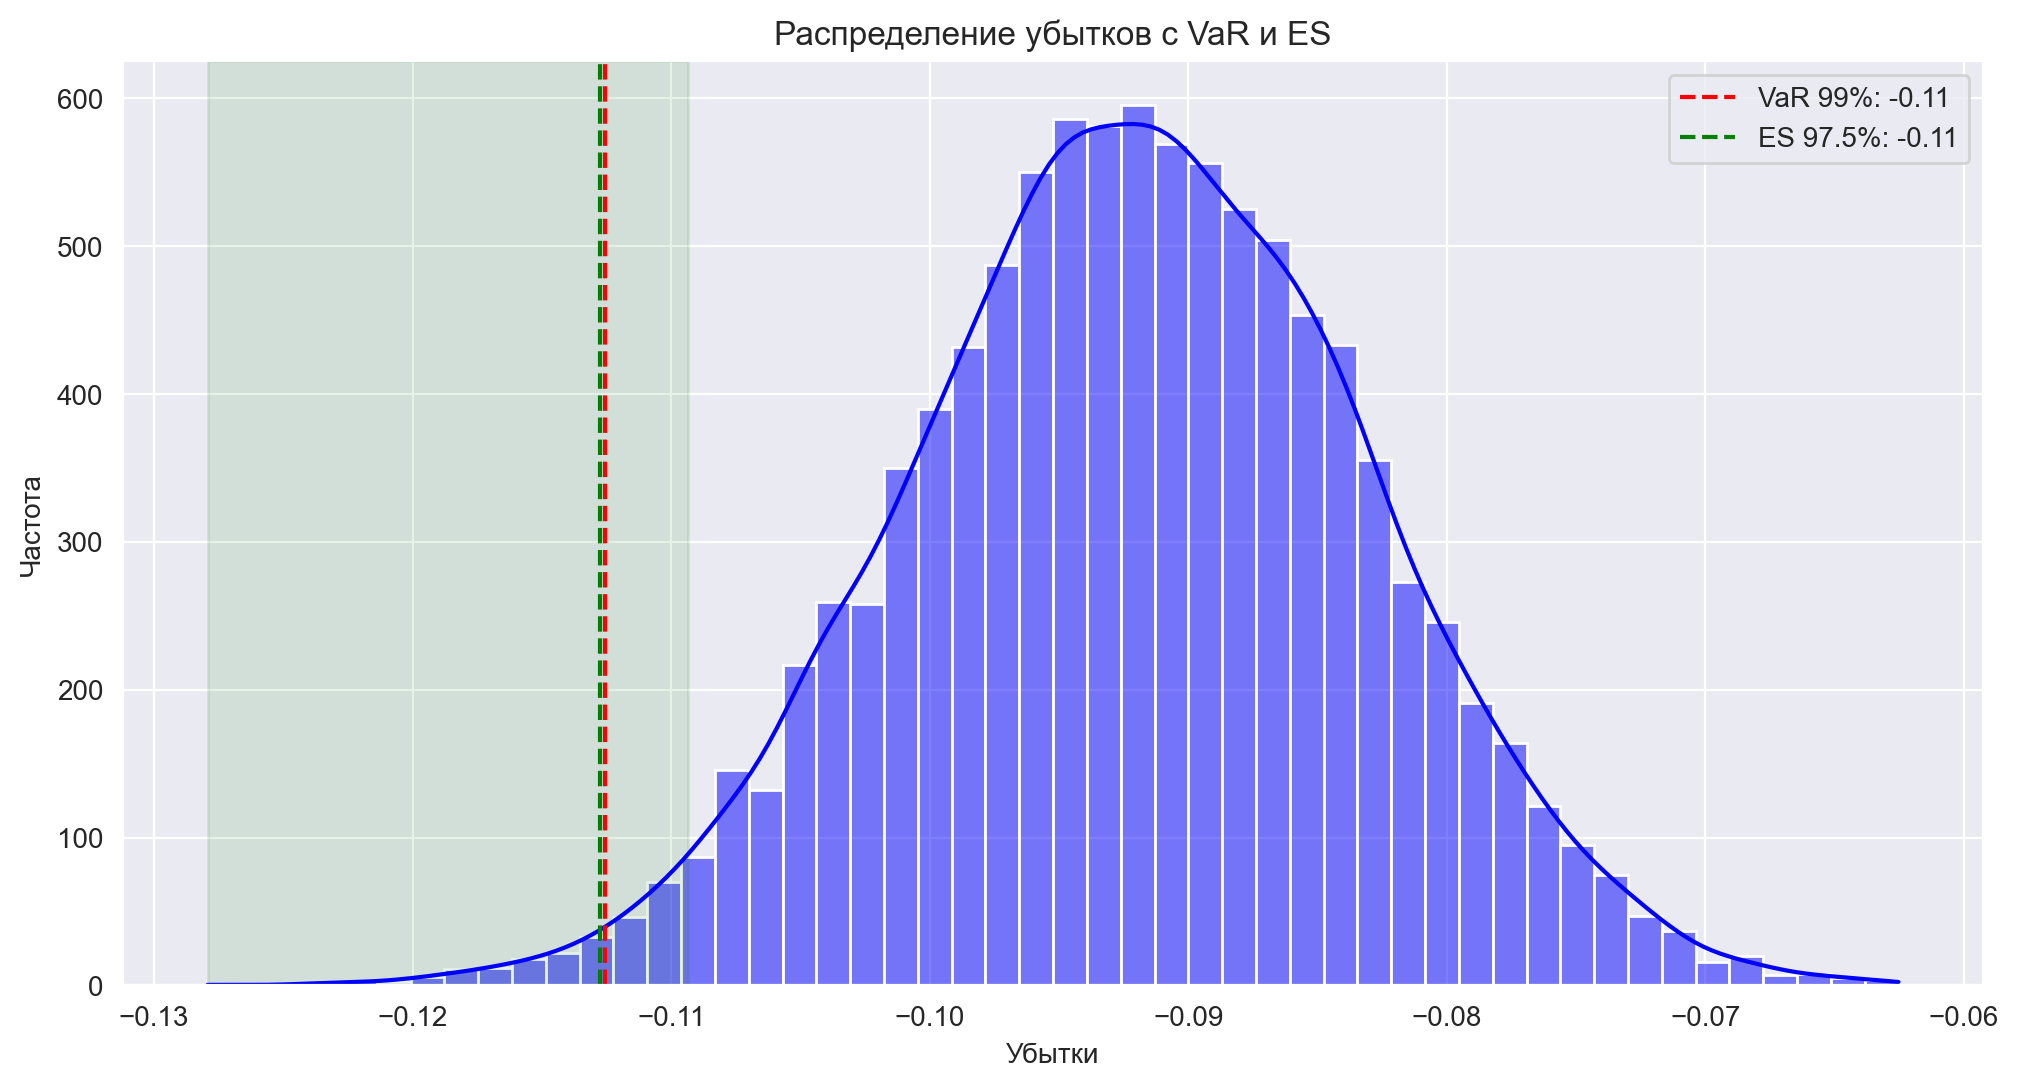

In [42]:
scenarios_data = get_scenarios_data(simulations, 1)
predicted_prices = predict_value(scenarios_data, models)
loss_profit_list = ((predicted_prices - base_prices.iloc[-1]) / base_prices.iloc[-1]  * shares_df.iloc[-1]).sum(axis=1).to_list()
draw_count_var_es(loss_profit_list)

Value-at-Risk (99%): -0.16
Expected Shortfall (97.5%): -0.16


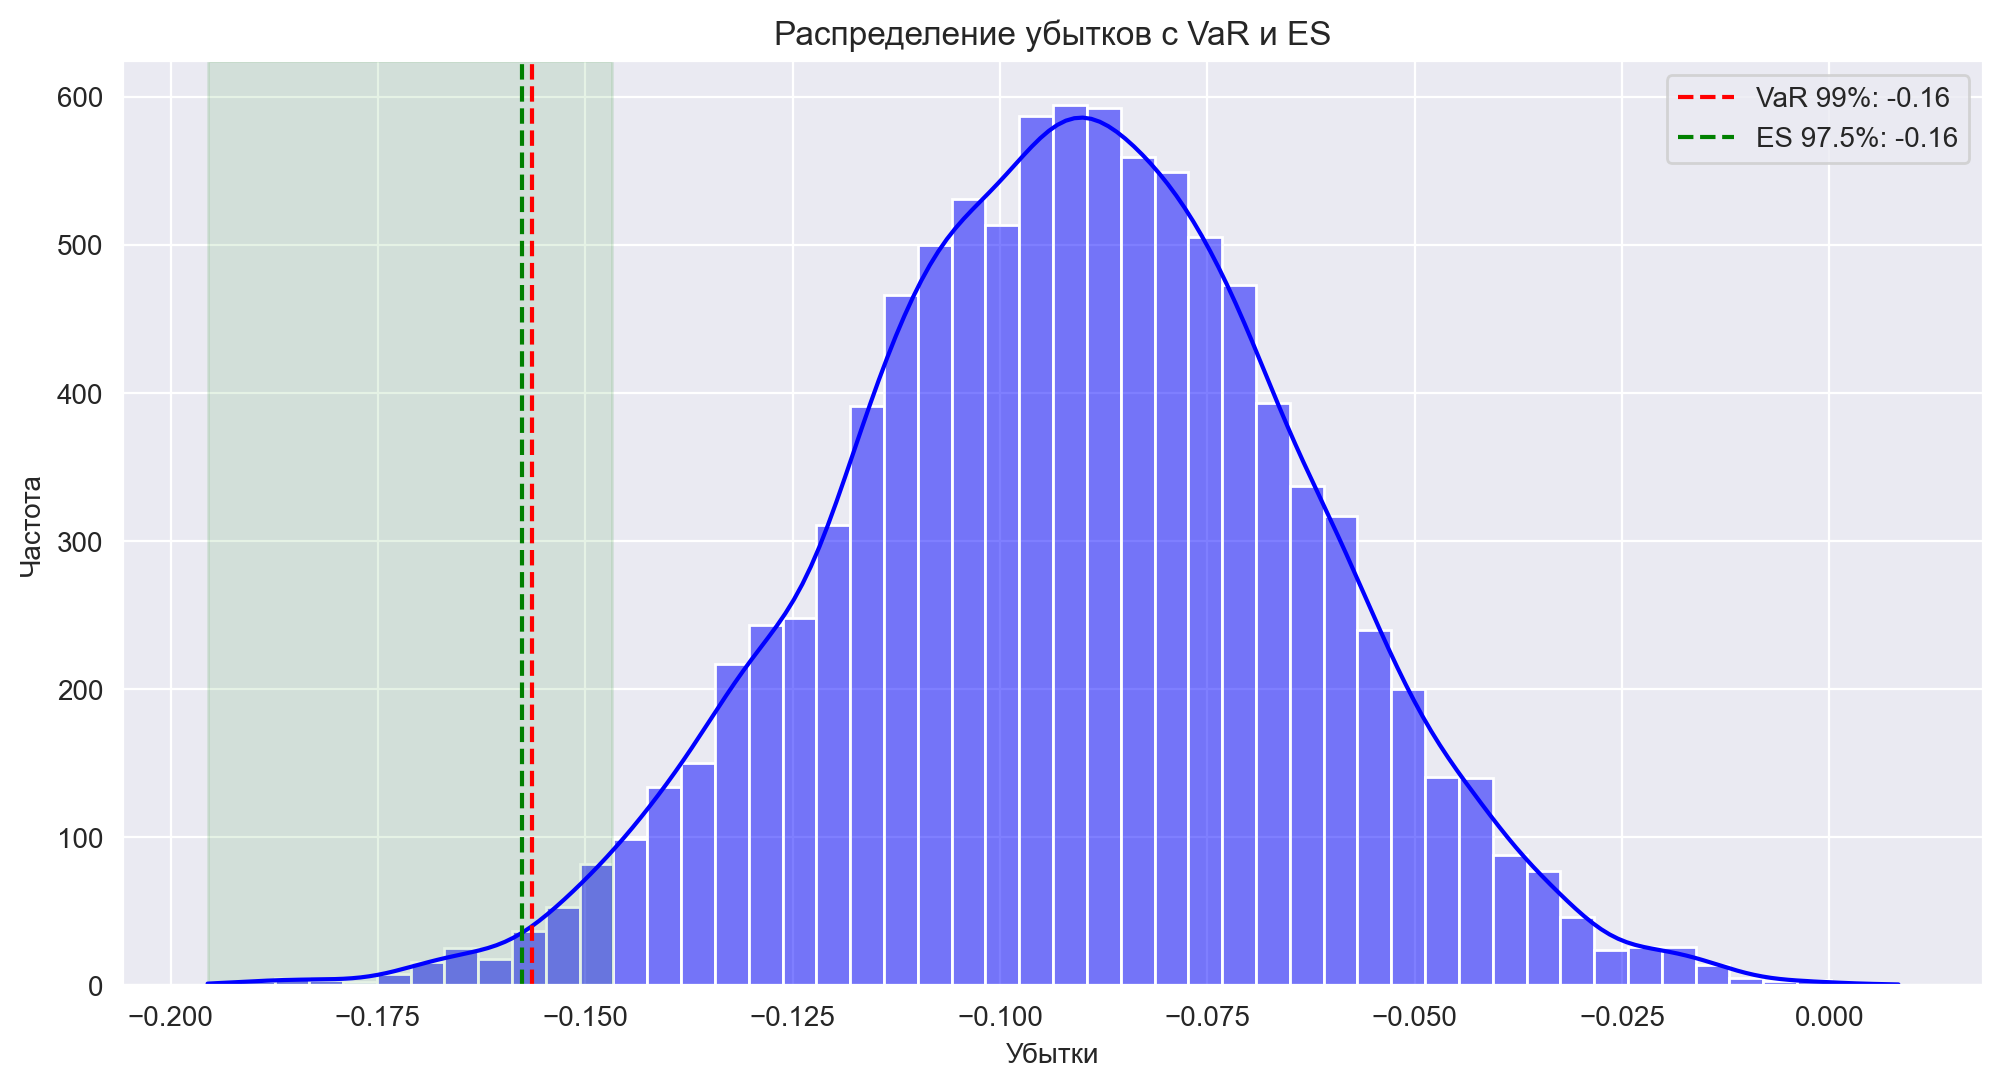

In [43]:
scenarios_data = get_scenarios_data(simulations, 10)
predicted_prices = predict_value(scenarios_data, models)
loss_profit_list = ((predicted_prices - base_prices.iloc[-1]) / base_prices.iloc[-1] * shares_df.iloc[-1]).sum(axis=1).to_list()
var = np.quantile(loss_profit_list, q=0.01)
draw_count_var_es(loss_profit_list)